In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random

H = nx.random_internet_as_graph(1000,seed=None)
G = nx.DiGraph(H)

node_list=sorted(list(G.nodes()), key=lambda x: nx.degree(G)[x],reverse=True)


for node in node_list:
  G.nodes[node]['nodepDamage']=0
  
for edge,ctdict in dict(G.edges).items():
  G.edges[edge]["weight2"]=1
  
  if ctdict["type"]=="transit":
    if str(edge[0])==ctdict["customer"]:
      G.edges[edge]["weight"]=2
      G.edges[edge]["vtype"]="2" 
    else:
      G.edges[edge]["weight"]=0 
      G.edges[edge]["vtype"]="4"
  else:
    G.edges[edge]["weight"]=1
    G.edges[edge]["vtype"]="6"


In [2]:
import datetime

now = str(datetime.datetime.now())
pos=nx.spring_layout(G) # positions for all nodes
fig = plt.figure(figsize = (70, 50))
# nodes
nx.draw_networkx_nodes(G,pos)
# edges
nx.draw_networkx_edges(G,pos,width=1,alpha=0.5,edge_color='black')
# labels
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
# nx.draw_networkx_edge_labels(G,pos,edgelabeldict)
# fig.savefig(now+"/content/drive/MyDrive/graphs/グラフ全体図"+"img.png")
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [3]:
#関数パート

import re
from collections import defaultdict
from heapq import *


def pathtovalleyfree5(inPath,node):
  vtypestr=""
  path2=inPath+[node]
  # print(inPath,path2,"node",node)
  for i in range(len(path2)):
    try:
      vtypestr+=str(G.edges[[path2[i],path2[i+1]]]["vtype"])  
      # print("try")                    #エッジのｐｐｃｐｐｃの順番の文字列
    except:
      # print("exc")
      pass

  # print("vtystr:",vtypestr)
  if vtypestr.count("6")>1 or re.findall(".*4.*2.*",vtypestr) or re.findall(".*4.*6.*",vtypestr) or re.findall(".*6.*2.*",vtypestr):  #不可能な文字列だと
    return False 
  else:
    return True


def gdijkstra5(f):
    q, seen, mins = [(0,f,[])], set(), {f: [0,[f]]}
    seen.add(f)
    for v2 in list(G.neighbors(f)):
      c =G.edges[f,v2]["weight"]
      mins[v2] = [c,[f,v2]]
      heappush(q, (c, v2, [f]))
    while q:
      (cost,v1,path) = heappop(q)
      # print(cost,v1,path, q, seen, mins)
      if v1 not in seen:
          seen.add(v1)
          path3=path+[v1]
          # if len(mins)==G.number_of_nodes(): return sorted(mins)
          for v2 in list(G.neighbors(v1)):
              c =G.edges[v1,v2]["weight2"]
              # print("v1:",v1,"v2:",v2,c)
              if v2 in seen : continue
              prev = mins.get(v2, None)
              next = cost + c
              if (prev is None or next < prev[0]) and pathtovalleyfree5(path3,v2):
                  mins[v2] = [next,path3+[v2]]
                  heappush(q, (next, v2, path3))

    return mins

#導入率を受けとり、２パターンの導入率におけるダメージ量の属性を初期化、１パターン非導入２パターン非導入１２パたRPKI色
def dep_sta(rate):
  dep_AS=random.sample(node_list,int(len(node_list)*rate/100)) #ある導入率をもとにランダムに選出
  ndep_AS=[i for i in node_list if i not in dep_AS]
  
  top_dep_AS=[pair[0] for pair in sorted(list(G.degree()),reverse=True,key=lambda x:x[1])[0:int(len(node_list)*rate/100)]] #ある導入率をもとに次数順に選出
  top_ndep_AS=[i for i in node_list if i not in top_dep_AS]

  for AS in ndep_AS:
    G.nodes[AS]["rpki"]="r"
    G.nodes[AS]["Cost"]=0
    G.nodes[AS]['damage0']=0
    # G.nodes[AS]['nodepDamage']=0
  for AS in dep_AS:
    G.nodes[AS]["rpki"]="b"
    G.nodes[AS]["Cost"]=500*math.log(nx.degree(G)[AS])
    G.nodes[AS]['damage0']=0
    # G.nodes[AS]['nodepDamage']=0
  for AS in top_dep_AS:
    G.nodes[AS]["top_rpki"]="b"
    G.nodes[AS]["top_Cost"]=500*math.log(nx.degree(G)[AS])
    G.nodes[AS]['damage1']=0
  for AS in top_ndep_AS:
    G.nodes[AS]["top_rpki"]="r"
    G.nodes[AS]["top_Cost"]=0
    G.nodes[AS]['damage1']=0
   
  return (ndep_AS,top_ndep_AS,[G.nodes[AS]['rpki'] for AS in sorted(node_list)],[G.nodes[AS]['top_rpki'] for AS in sorted(node_list)],dep_AS,top_dep_AS) #ランダム選出AS、次数順選出AS、ランダム順色、次数順色

#導入率を受け取り、ダメージを受けるASを計算して、２パターンのダメージ量を返す
def ratio_damage(ratio):
  ndep=dep_sta(ratio)
  for i in [0,1]:
    #中間ASが導入していないことによりダメージを受けるODのペア
    damage_add=set()
    #0:ランダムにチョイスする 1:次数順に導入する
    for AS in ndep[i]:
      try:
        for od_pair_bymidAS in AS_OD_dic[AS]:
          damage_add.add(od_pair_bymidAS)
        for od_pair_byoriginal in OD_pair[AS]:
          damage_add.add(od_pair_byoriginal)
      except:
        pass
    for (origin,destination) in damage_add:
      G.nodes[origin]['damage'+str(i)]+= int(nx.degree(G)[origin]/2) * int(nx.degree(G)[destination]/2)
      G.nodes[destination]['damage'+str(i)]+=int(nx.degree(G)[destination]/2) * int(nx.degree(G)[origin]/2)

  return ([G.nodes[AS]['nodepDamage']-2*G.nodes[AS]['damage0']- G.nodes[AS]['Cost'] for AS in node_list],[G.nodes[AS]['nodepDamage']- 2*G.nodes[AS]['damage1'] - G.nodes[AS]['top_Cost']for AS in node_list],ndep)#ランダム導入時の損得、次数導入時の損得、上記関数
# 　return ([G.nodes[AS]['nodepDamage']*0.1-G.nodes[AS]['damage0'] for AS in node_list],[G.nodes[AS]['nodepDamage']*0.1-G.nodes[AS]['damage1'] for AS in node_list],ndep)


In [5]:

from collections import defaultdict
# damage_receive=100
AS_OD_dic=defaultdict(list)
OD_pair=defaultdict(list)
#始点：node 終点：key
for node in node_list:
  # G.nodes[node]['nodepDamage']=0
  for keys,values in gdijkstra5(node).items():
    #導入がゼロの時のダメージ量の最低を求める
    G.nodes[node]['nodepDamage']+=1 * int(nx.degree(G)[node]/2) * int(nx.degree(G)[keys]/2) 
    G.nodes[keys]['nodepDamage']+=1 * int(nx.degree(G)[node]/2) * int(nx.degree(G)[keys]/2) 
    #その始点ASと終点ASのペアを作る
    OD_pair[node].append((node,keys))
    OD_pair[node].append((keys,node))

    for i in values[1][1:-1]:
      AS_OD_dic[i].append((node,keys))


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pickle 

with open('/content/drive/MyDrive/データピクルス/1000AS_OD_dic.binaryfile', 'wb') as file1:
  pickle.dump(AS_OD_dic , file1)
with open('/content/drive/MyDrive/データピクルス/1000OD_pair.binaryfile', 'wb') as file2:
  pickle.dump(OD_pair , file2)
  '''
  
with open('/content/drive/MyDrive/データピクルス/AS_OD_dic.binaryfile', 'rb') as file1:
  AS_OD_dic= pickle.load(file1)
with open('/content/drive/MyDrive/データピクルス/OD_pair.binaryfile', 'rb') as file2:
  OD_pair= pickle.load(file2)
'''

ダメージにノイズを入れる
コストを規模に比例させる
イニシャルとランニングコストをわける

[5.099866427824199, 5.087596335232384, 4.804021044733257, 4.605170185988092, 4.477336814478207, 4.454347296253507, 4.276666119016055, 4.276666119016055, 4.248495242049359, 4.219507705176107, 4.219507705176107, 4.060443010546419, 3.9889840465642745, 3.9512437185814275, 3.912023005428146, 3.871201010907891, 3.828641396489095, 3.828641396489095, 3.784189633918261, 3.784189633918261, 3.7376696182833684, 3.7376696182833684, 3.7376696182833684, 3.7376696182833684, 3.6888794541139363, 3.6888794541139363, 3.6888794541139363, 3.6375861597263857, 3.6375861597263857, 3.6375861597263857, 3.58351893845611, 3.58351893845611, 3.5263605246161616, 3.5263605246161616, 3.5263605246161616, 3.4657359027997265, 3.4657359027997265, 3.4657359027997265, 3.4657359027997265, 3.4657359027997265, 3.4011973816621555, 3.4011973816621555, 3.4011973816621555, 3.4011973816621555, 3.4011973816621555, 3.4011973816621555, 3.4011973816621555, 3.332204510175204, 3.332204510175204, 3.332204510175204, 3.332204510175204, 3.258

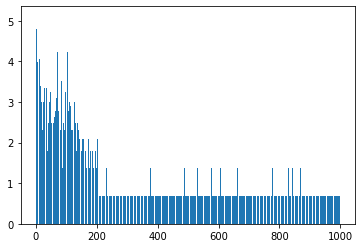

In [18]:
import math
unkolist=[]
for number in node_list:
  unkolist.append(math.log(nx.degree(G)[number]))
plt.bar(node_list,unkolist)
print(unkolist)
print(len([12]))

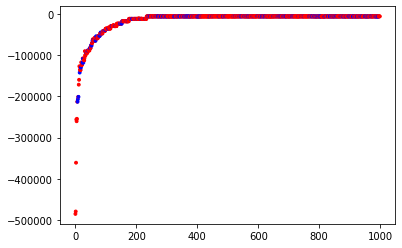

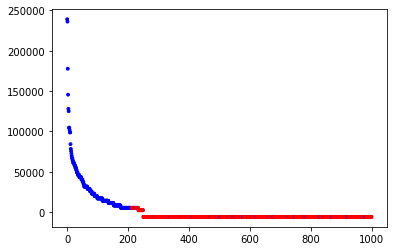

[0] [250] 750


In [21]:
import datetime
import numpy as np
now = str(datetime.datetime.now())

numberlist0=[]
numberlist1=[]
benefitdict={}
rate = 25
damage_list=ratio_damage(rate)

benefitdict[rate]=[damage_list[0],list(damage_list[2][2]),damage_list[1],list(damage_list[2][3])]
# [0]ランダム導入時の損得
# [1]次数導入時の損得
# [2]上記関数
#   [0]ランダム非導入AS
#   [1]次数順非導入AS
#   [2]ランダム順色
#   [3]次数順色
#   [4]ランダム導入AS
#   [5]次数順導入AS
numberlist1.append(sum([i>=0 for i in damage_list[1]]))
numberlist0.append(sum([i>=0 for i in damage_list[0]]))
plt.scatter(list(range(len(node_list))),damage_list[0],color=damage_list[2][2],s=8)
plt.show()
plt.scatter(list(range(len(node_list))),damage_list[1],color=damage_list[2][3],s=8)
plt.show()
print(numberlist0,numberlist1,sum([i<0 for i in damage_list[1]]))



In [19]:
'''
with open('/content/drive/MyDrive/データピクルス/damage_list.binaryfile', 'wb') as file1:
  pickle.dump(damage_list , file1)

'''
with open('/content/drive/MyDrive/データピクルス/damage_list.binaryfile', 'rb') as file1:
  damage_list= pickle.load(file1)


0.433


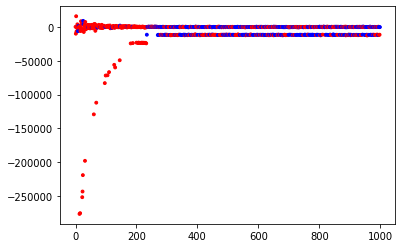

0.55


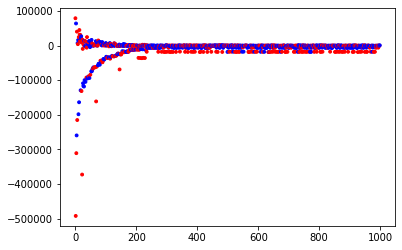

0.634


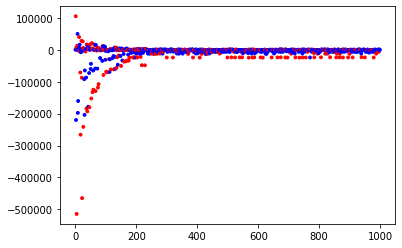

0.704


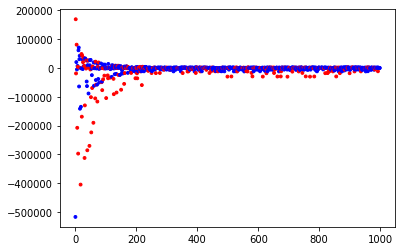

0.747


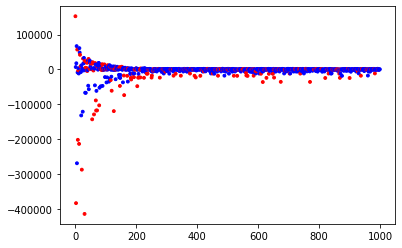

0.788


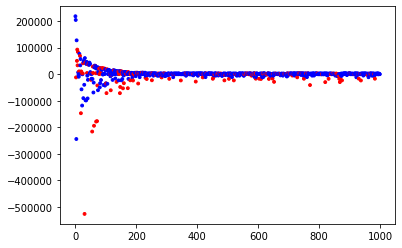

0.82


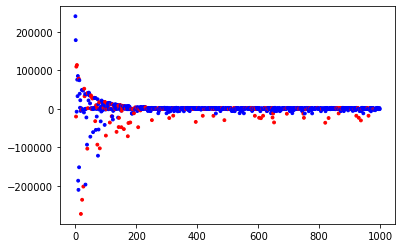

0.852


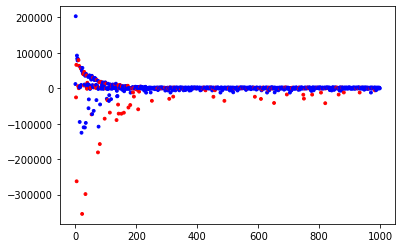

0.874


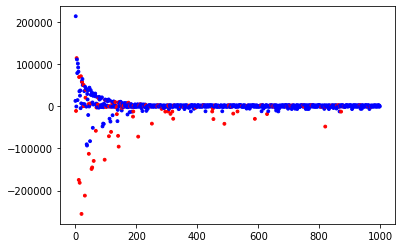

0.893


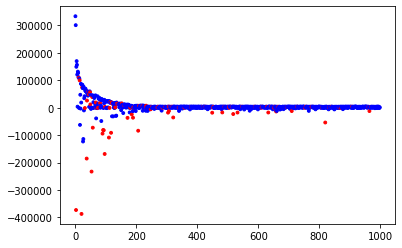

0.906


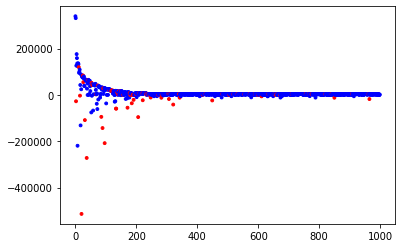

0.922


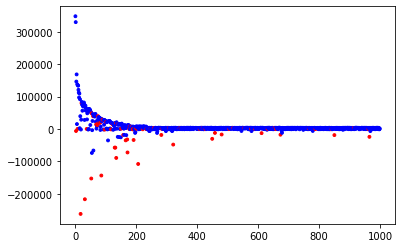

0.938


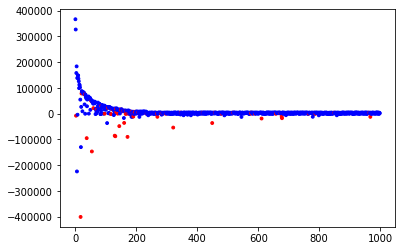

0.947


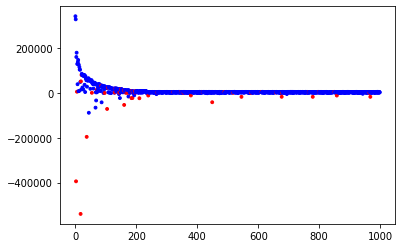

0.961


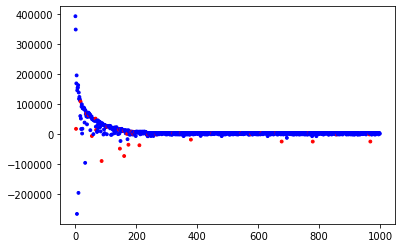

0.968


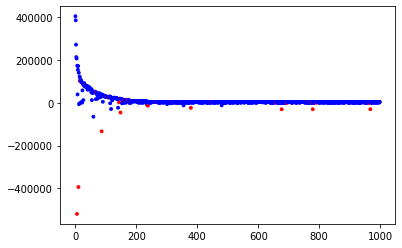

0.973


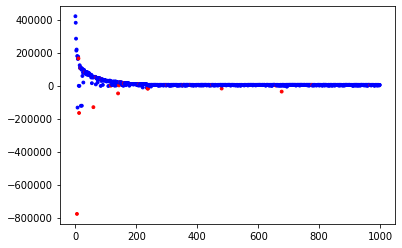

0.979


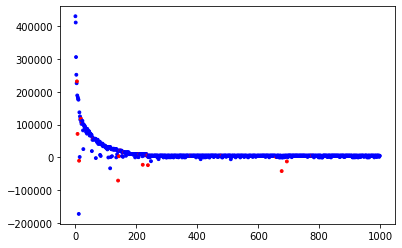

0.985


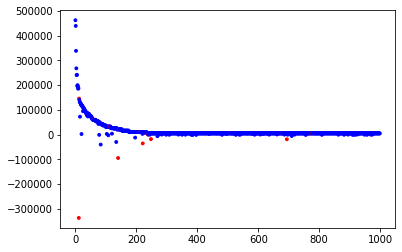

0.988


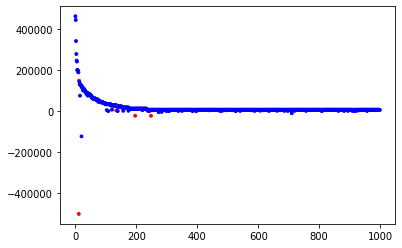

0.99


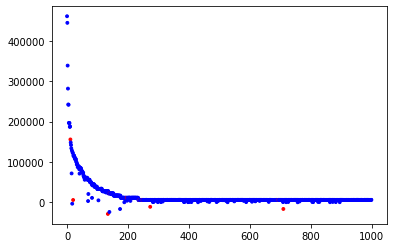

0.993


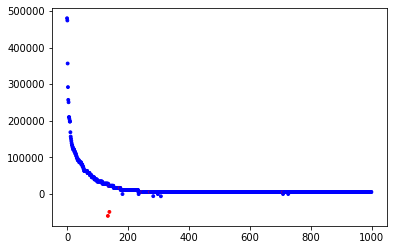

0.995


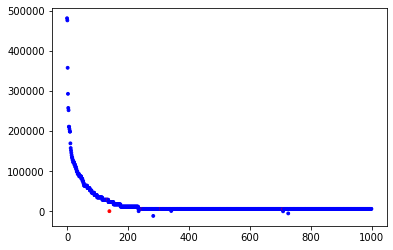

0.997


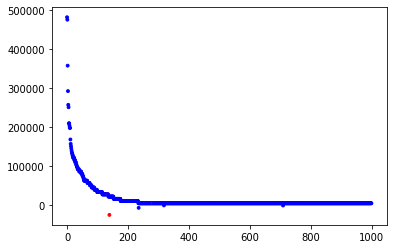

0.998


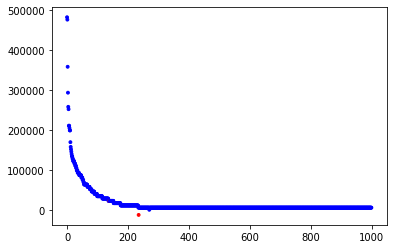

0.999


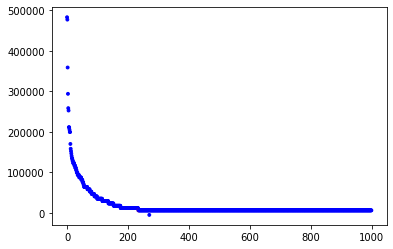

1.0


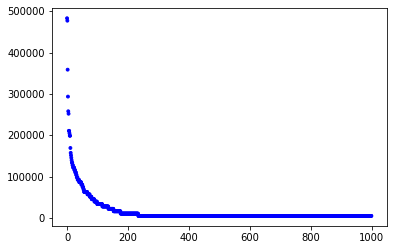

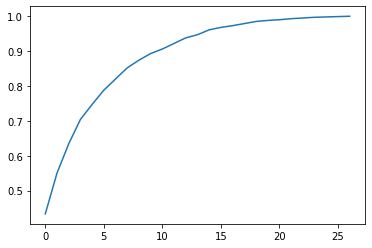

In [22]:
##################################################################
# with open('/content/drive/MyDrive/データピクルス/damage_list.binaryfile', 'rb') as file1:
#   damage_list= pickle.load(file1)
unko1list=[]
benefitorlosslist=[G.nodes[AS]['nodepDamage']-2*G.nodes[AS]['damage0']- G.nodes[AS]['Cost'] for AS in node_list]
while numberlist0[-1]!=1000: #導入が100％になるまで
 
  for randomndepnode in damage_list[2][0]: #ランダム導入で導入していないAS 
    # print(randomndepnode)
    G.nodes[randomndepnode]["rpki"]="r"
    G.nodes[randomndepnode]["Cost"]=0
    G.nodes[randomndepnode]['damage0']=0
    if benefitorlosslist[randomndepnode] > -6000: #導入していないASで損益が〜を上回ると
      damage_list[2][0].remove(randomndepnode)
      damage_list[2][4].append(randomndepnode)
      G.nodes[randomndepnode]["rpki"]="b"
      G.nodes[randomndepnode]["Cost"]=500*math.log(nx.degree(G)[randomndepnode])
      G.nodes[randomndepnode]['damage0']=0

  for randomdepnode in damage_list[2][4]: #ランダム導入で導入AS 
    G.nodes[randomdepnode]["rpki"]="b"
    G.nodes[randomdepnode]["Cost"]=500*math.log(nx.degree(G)[randomdepnode])
    G.nodes[randomdepnode]['damage0']=0
    if benefitorlosslist[randomdepnode] <= -6000: #導入しているASで損益が〜を下回ると
      damage_list[2][4].remove(randomdepnode)
      damage_list[2][0].append(randomdepnode)
      G.nodes[randomdepnode]["rpki"]='r'
      G.nodes[randomdepnode]["Cost"]=0
      G.nodes[randomdepnode]['damage0']=0

  damage_add=set()
  for AS in damage_list[2][0]:
      try:
        for od_pair_bymidAS in AS_OD_dic[AS]:
          damage_add.add(od_pair_bymidAS)
        for od_pair_byoriginal in OD_pair[AS]:
          damage_add.add(od_pair_byoriginal)
      except:
        pass
  for (origin,destination) in damage_add:
      G.nodes[origin]['damage0']+= int(nx.degree(G)[origin]/2) * int(nx.degree(G)[destination]/2)*random.random()
      G.nodes[destination]['damage0']+=int(nx.degree(G)[destination]/2) * int(nx.degree(G)[origin]/2)*random.random()
  
  benefitorlosslist=[G.nodes[AS]['nodepDamage']-2*G.nodes[AS]['damage0']- G.nodes[AS]['Cost'] for AS in node_list]
  colorlist=[G.nodes[AS]['rpki'] for AS in sorted(node_list)]

  # fig = plt.figure(figsize = (35, 25))
  plt.scatter(list(range(len(node_list))),benefitorlosslist,color=colorlist,marker="o",s=8)
  numberlist0.append(sum([i>=0 for i in benefitorlosslist]))
  print(len([blue for blue in colorlist if blue=='b'])/1000)
  unko1list.append(len([blue for blue in colorlist if blue=='b'])/1000)
  plt.show()
plt.plot(unko1list)
##################################################################

In [1]:
##################################################################
with open('/content/drive/MyDrive/データピクルス/damage_list.binaryfile', 'rb') as file1:
  damage_list= pickle.load(file1)

benefitorlosslist=[G.nodes[AS]['nodepDamage']- 2*G.nodes[AS]['damage1'] - G.nodes[AS]['top_Cost']for AS in node_list]
plt.scatter(list(range(len(node_list))),benefitorlosslist,s=8)
plt.show()
while numberlist1[-1]!=100: #導入が100％になるまで
  for topndepnode in damage_list[2][1]: #次数順導入で導入していないAS 
    G.nodes[topndepnode]["top_rpki"]="r"
    G.nodes[topndepnode]["top_Cost"]=0
    G.nodes[topndepnode]['damage1']=0   
    if benefitorlosslist[topndepnode] > -2000:
      damage_list[2][1].remove(topndepnode)
      damage_list[2][5].append(topndepnode)
      G.nodes[topndepnode]["top_rpki"]="b"
      G.nodes[topndepnode]["top_Cost"]=500*math.log(nx.degree(G)[topndepnode])
      G.nodes[topndepnode]['damage1']=0  

  for topdepnode in damage_list[2][5]: #次数順導入で導入AS 
    G.nodes[topdepnode]["top_rpki"]="b"
    G.nodes[topdepnode]["top_Cost"]=500*math.log(nx.degree(G)[topdepnode])
    G.nodes[topdepnode]['damage1']=0
    if benefitorlosslist[topdepnode] <= -10000:
      damage_list[2][5].remove(topdepnode)
      damage_list[2][1].append(topdepnode)
      G.nodes[topdepnode]["top_rpki"]="r"
      G.nodes[topdepnode]["top_Cost"]=0
      G.nodes[topdepnode]['damage1']=0

  damage_add=set()
  for AS in damage_list[2][1]:
      try:
        for od_pair_bymidAS in AS_OD_dic[AS]:
          damage_add.add(od_pair_bymidAS)
        for od_pair_byoriginal in OD_pair[AS]:
          damage_add.add(od_pair_byoriginal)
      except:
        pass
  for (origin,destination) in damage_add:
      G.nodes[origin]['damage1']+= int(nx.degree(G)[origin]/2) * int(nx.degree(G)[destination]/2)*random.random()
      G.nodes[destination]['damage1']+=int(nx.degree(G)[destination]/2) * int(nx.degree(G)[origin]/2)*random.random()
  
  benefitorlosslist=[G.nodes[AS]['nodepDamage']- 2*G.nodes[AS]['damage1'] - G.nodes[AS]['top_Cost']for AS in node_list]
  colorlist=[G.nodes[AS]['top_rpki'] for AS in sorted(node_list)]

  plt.scatter(list(range(len(node_list))),benefitorlosslist,color=colorlist,s=8)
  numberlist1.append(sum([i>=0 for i in benefitorlosslist]))
  plt.show()
##################################################################

FileNotFoundError: ignored

In [ ]:
#利益得るAS数変化グラフの平均化プログラム
numlist0=[0]*21
numlist1=[0]*21

for i in range(100):
  print(i,'回目')
  numlist00=[]
  numlist11=[]
  for rate in range(0,105,5):
    print(rate,'%')
    damage_list=ratio_damage(rate)
    numlist00.append(sum([i>=0 for i in damage_list[1]]))
    numlist11.append(sum([i>=0 for i in damage_list[0]]))

  numlist1=[x + y for (x, y) in zip(numlist1, numlist11)]
  numlist0=[x + y for (x, y) in zip(numlist0, numlist00)]

numlist1=list(map(lambda x: x /100 , numlist1))
numlist0=list(map(lambda x: x /100 , numlist0))

import pickle
with open('/content/drive/MyDrive/datafile/benefitnumlist0.binaryfile', 'wb') as web1:
  pickle.dump(numlist0 , web1)
with open('/content/drive/MyDrive/datafile/benefitnumlist1.binaryfile', 'wb') as web2:
  pickle.dump(numlist1, web2)

0 回目
0 %
5 %
10 %
15 %
20 %
25 %


KeyboardInterrupt: ignored

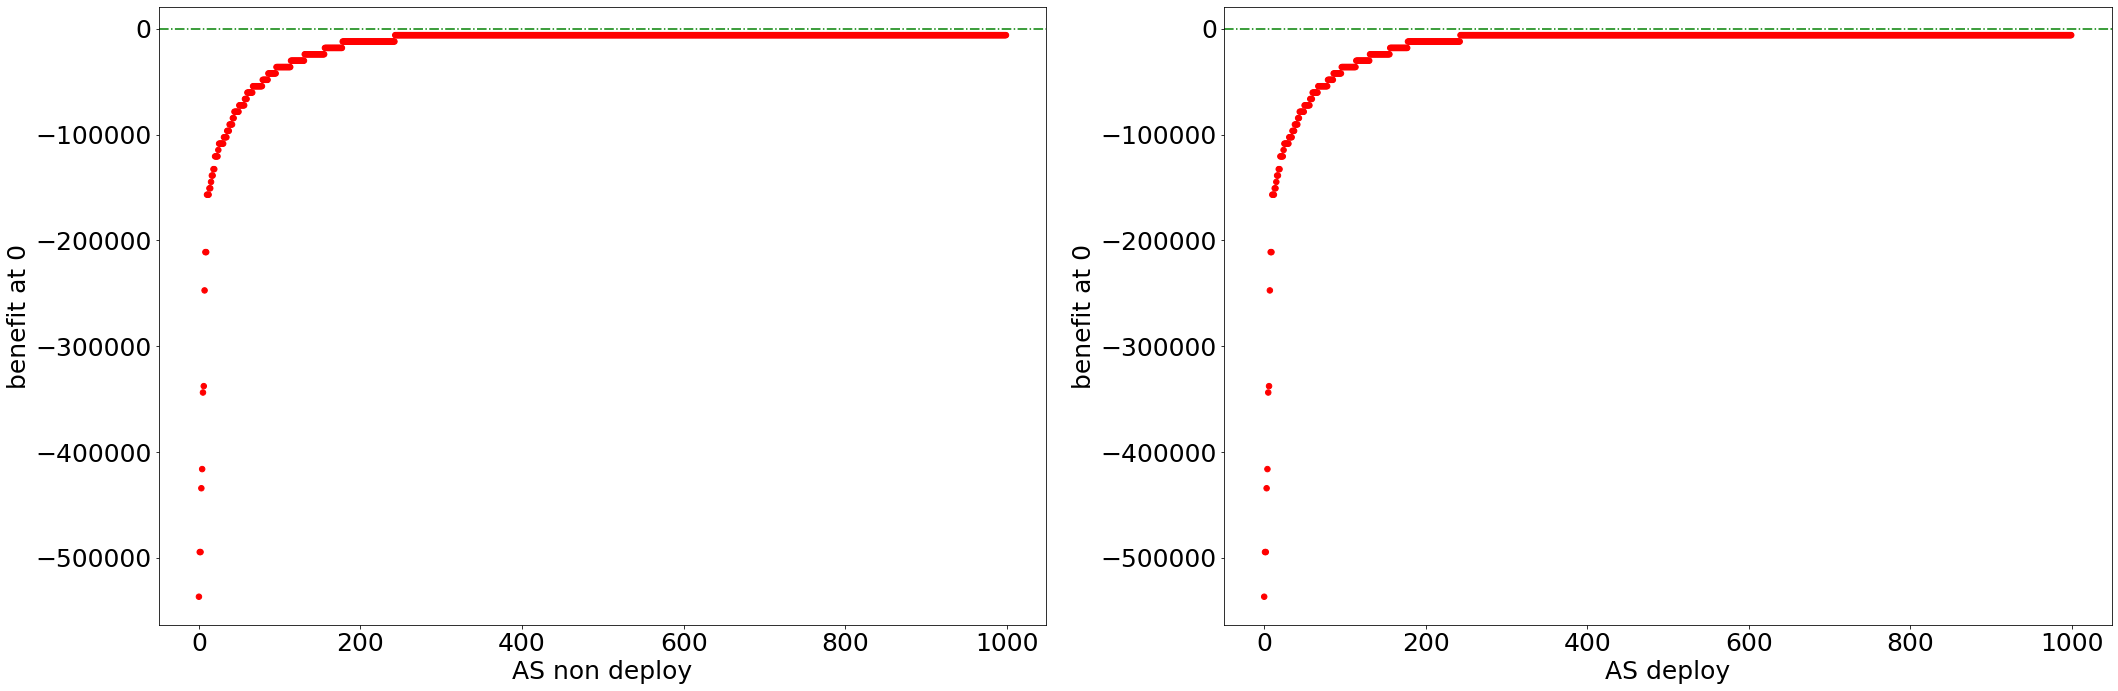

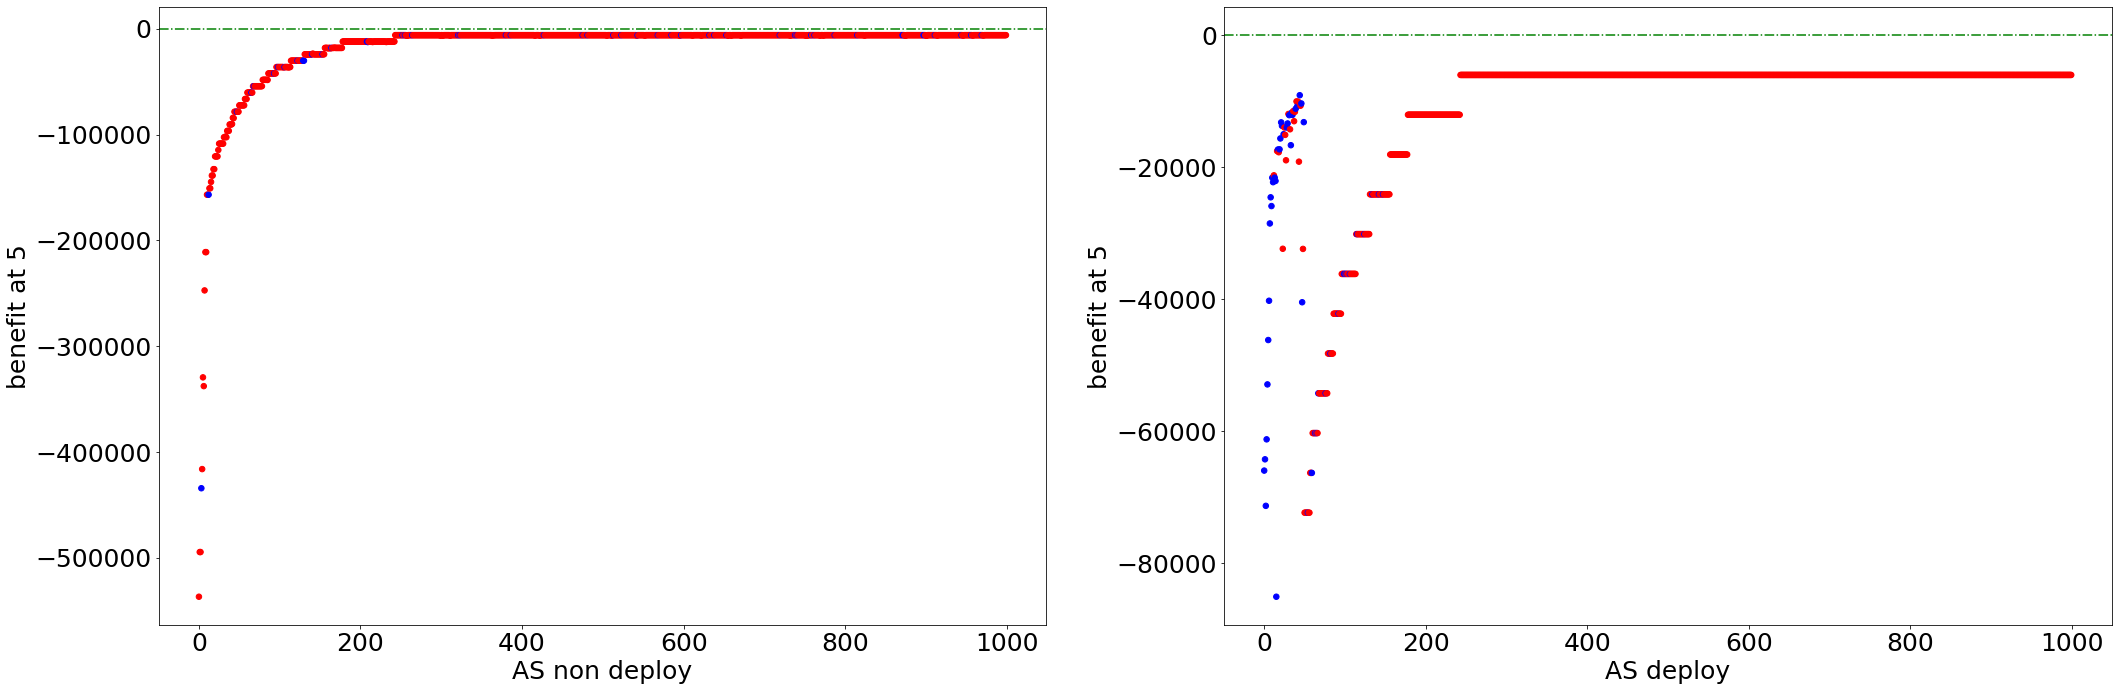

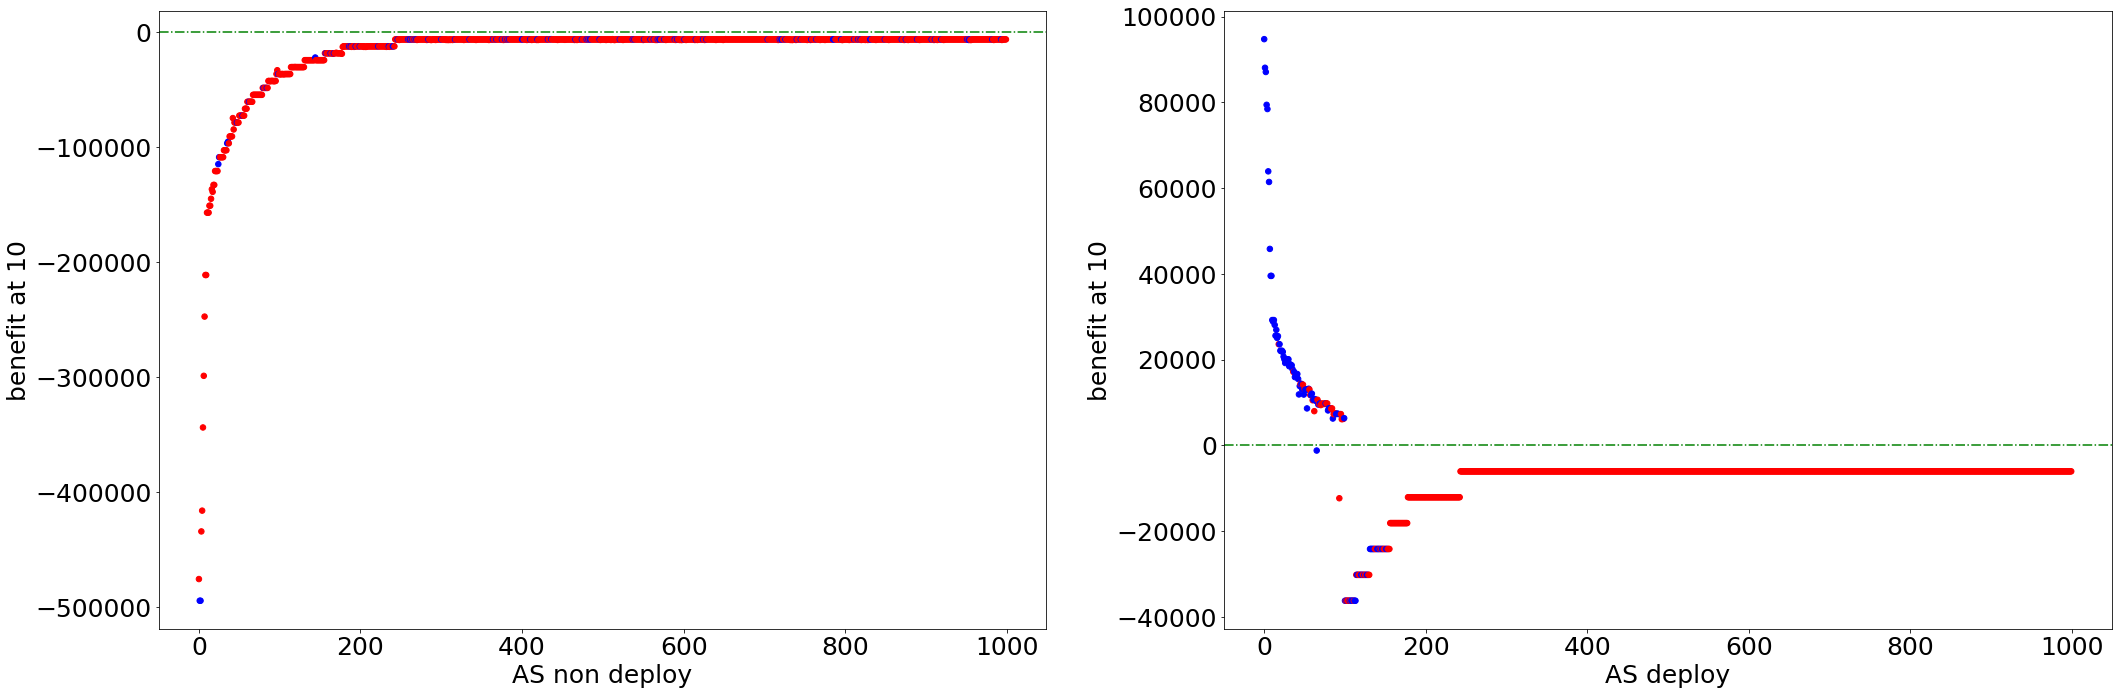

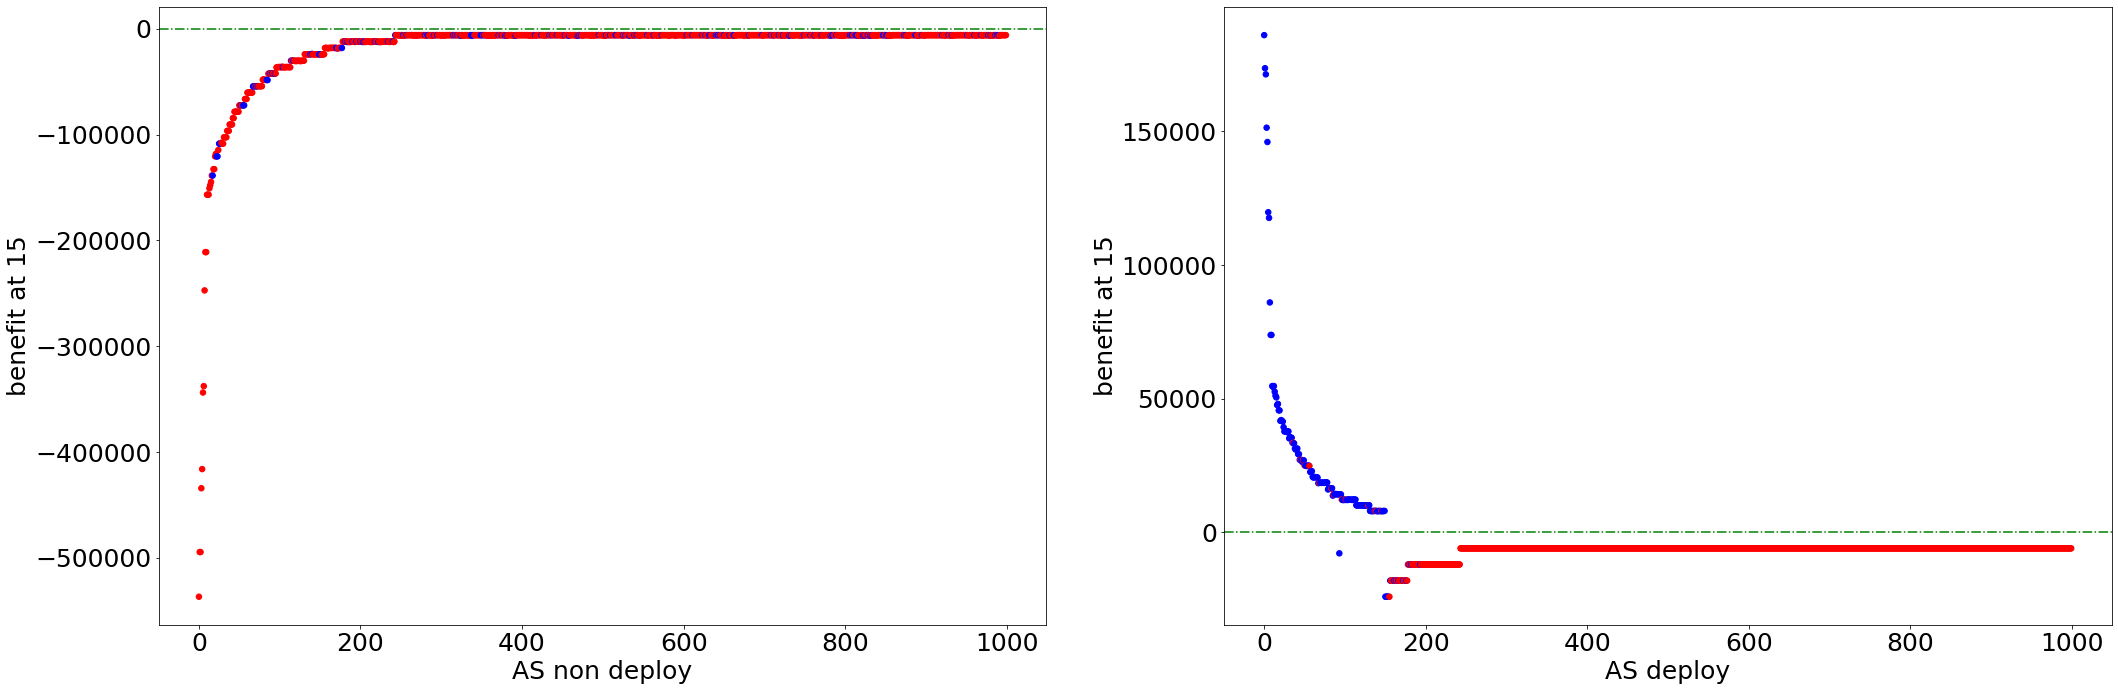

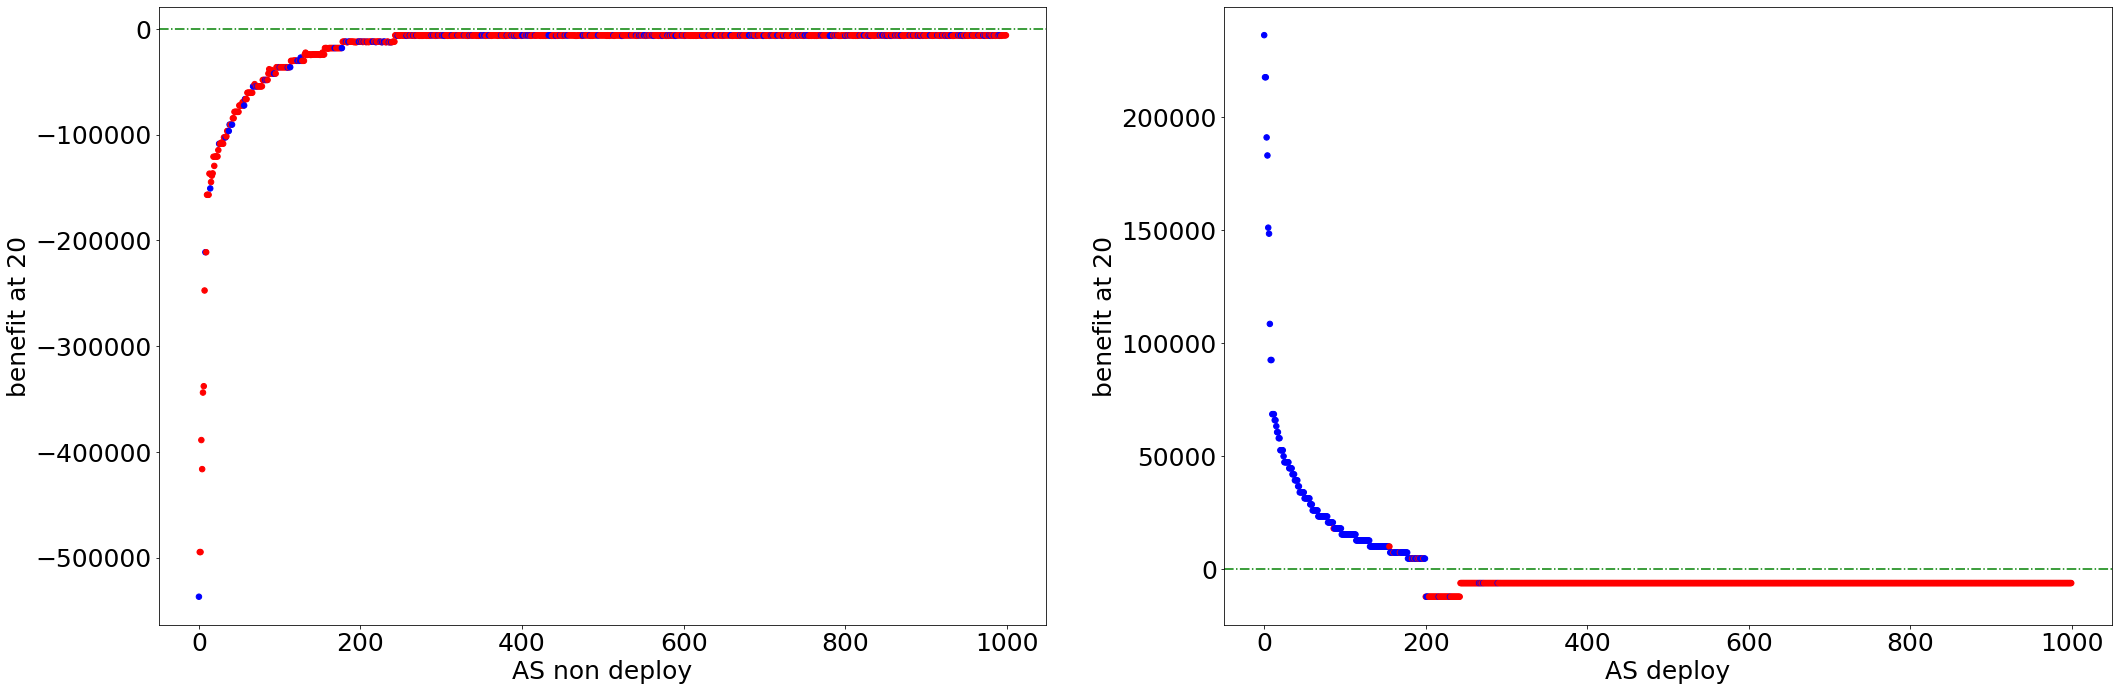

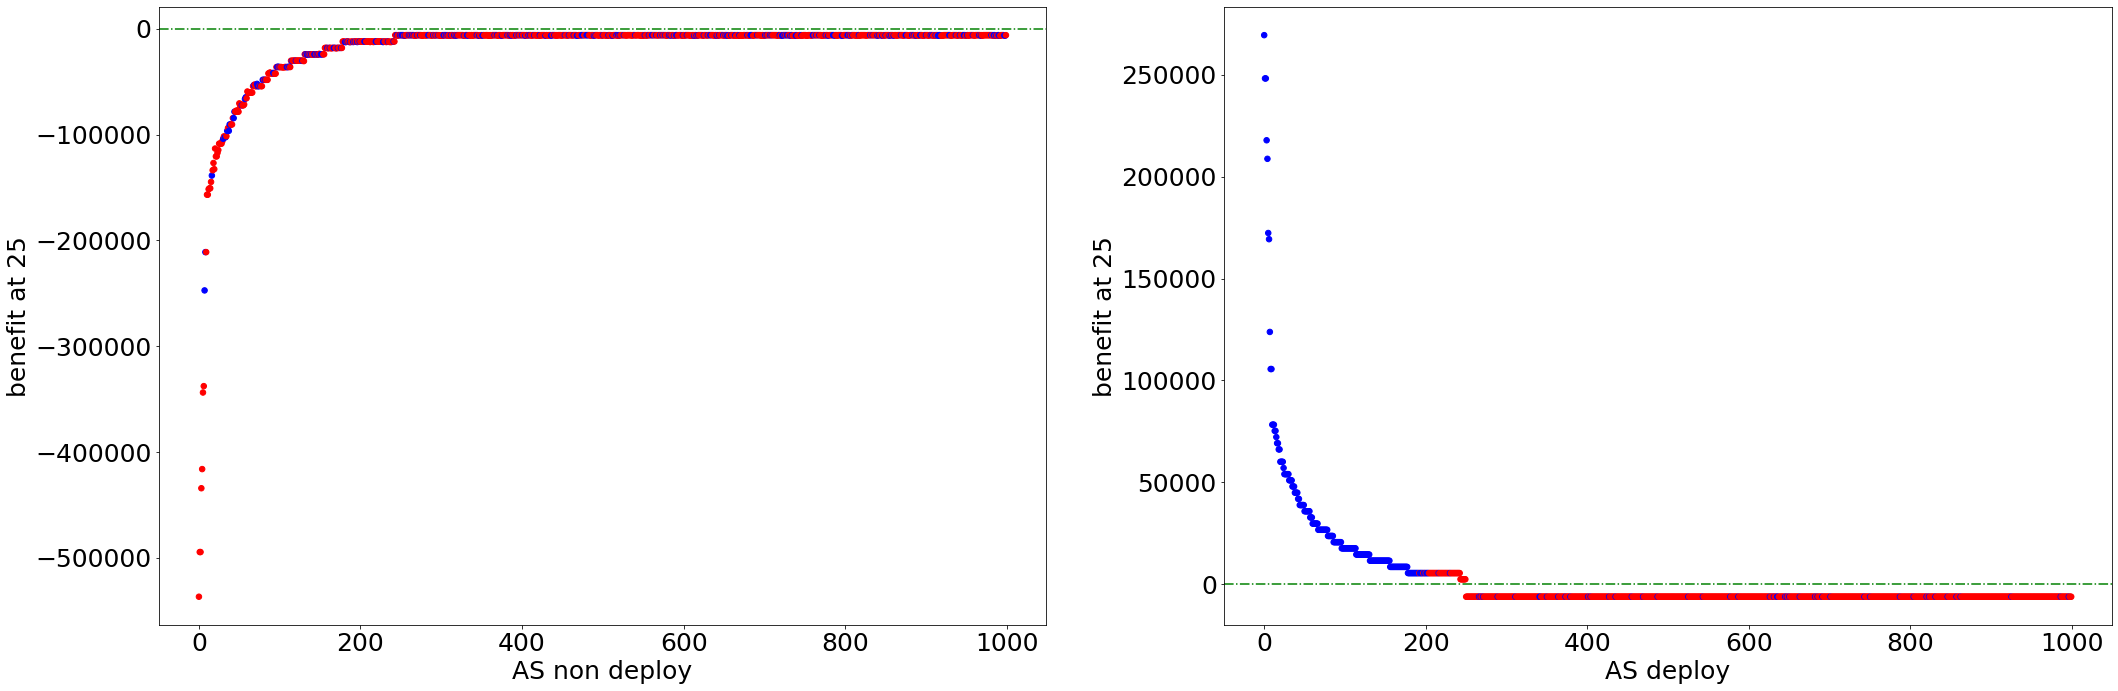

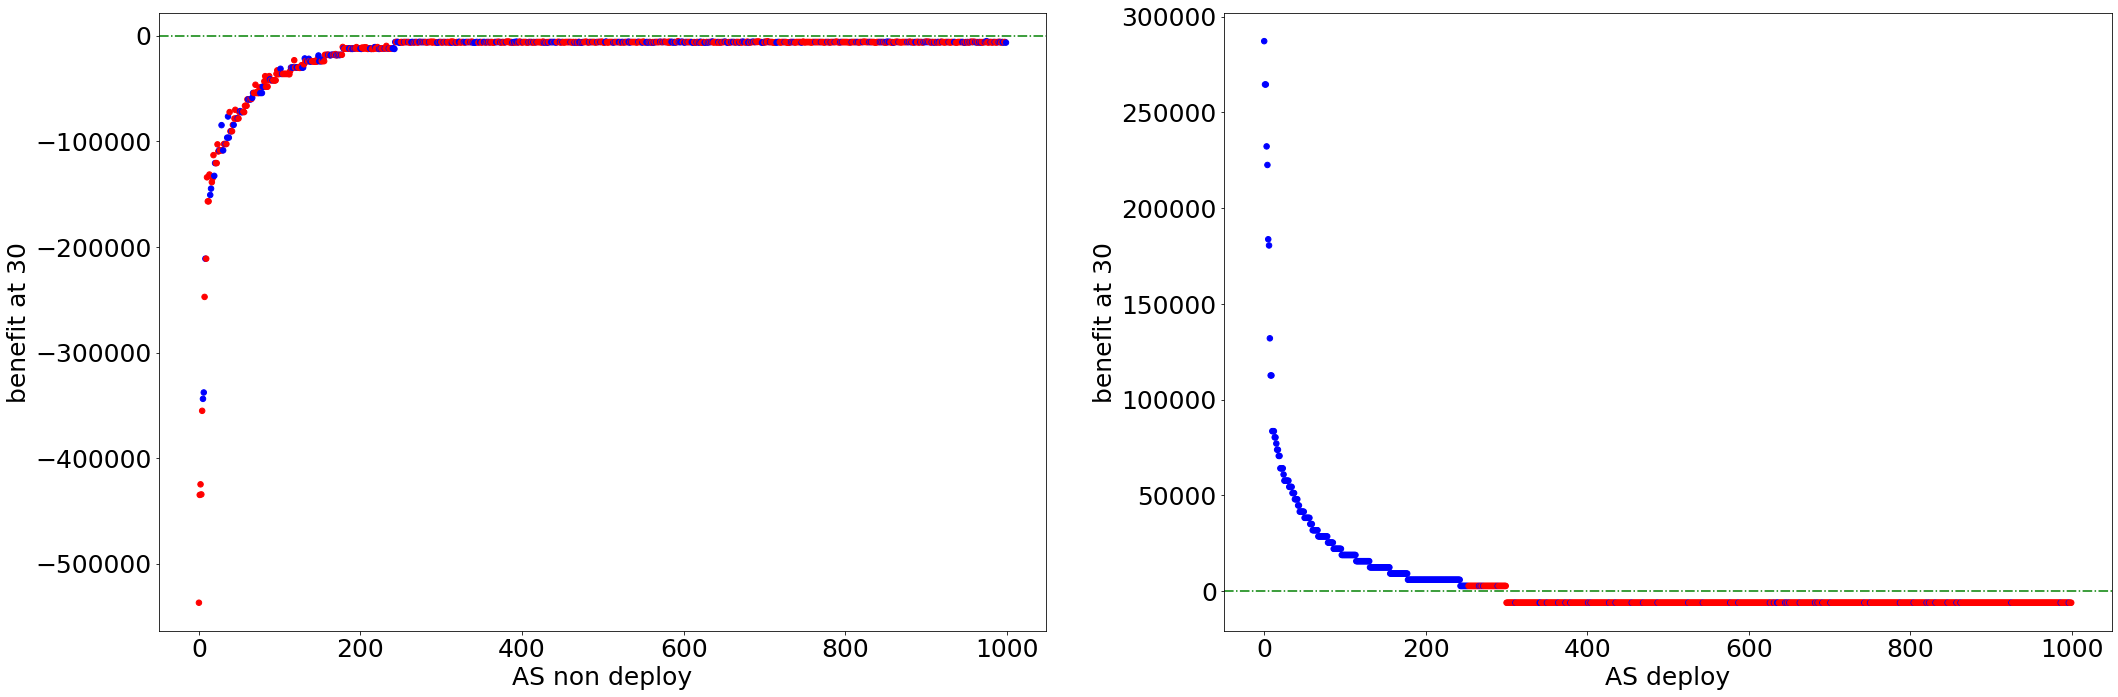

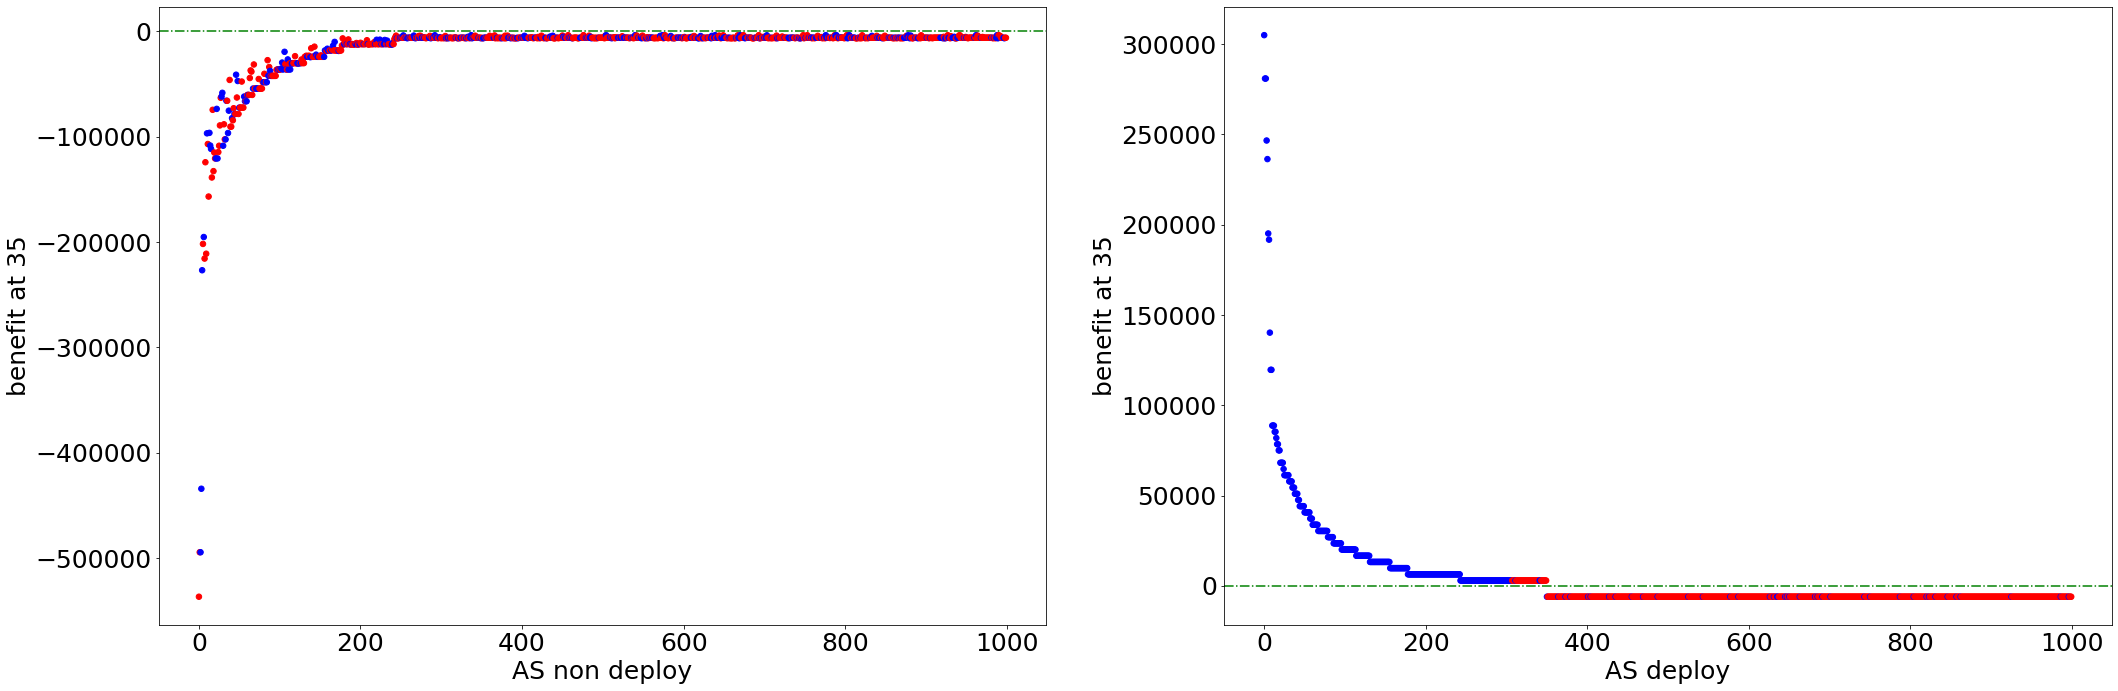

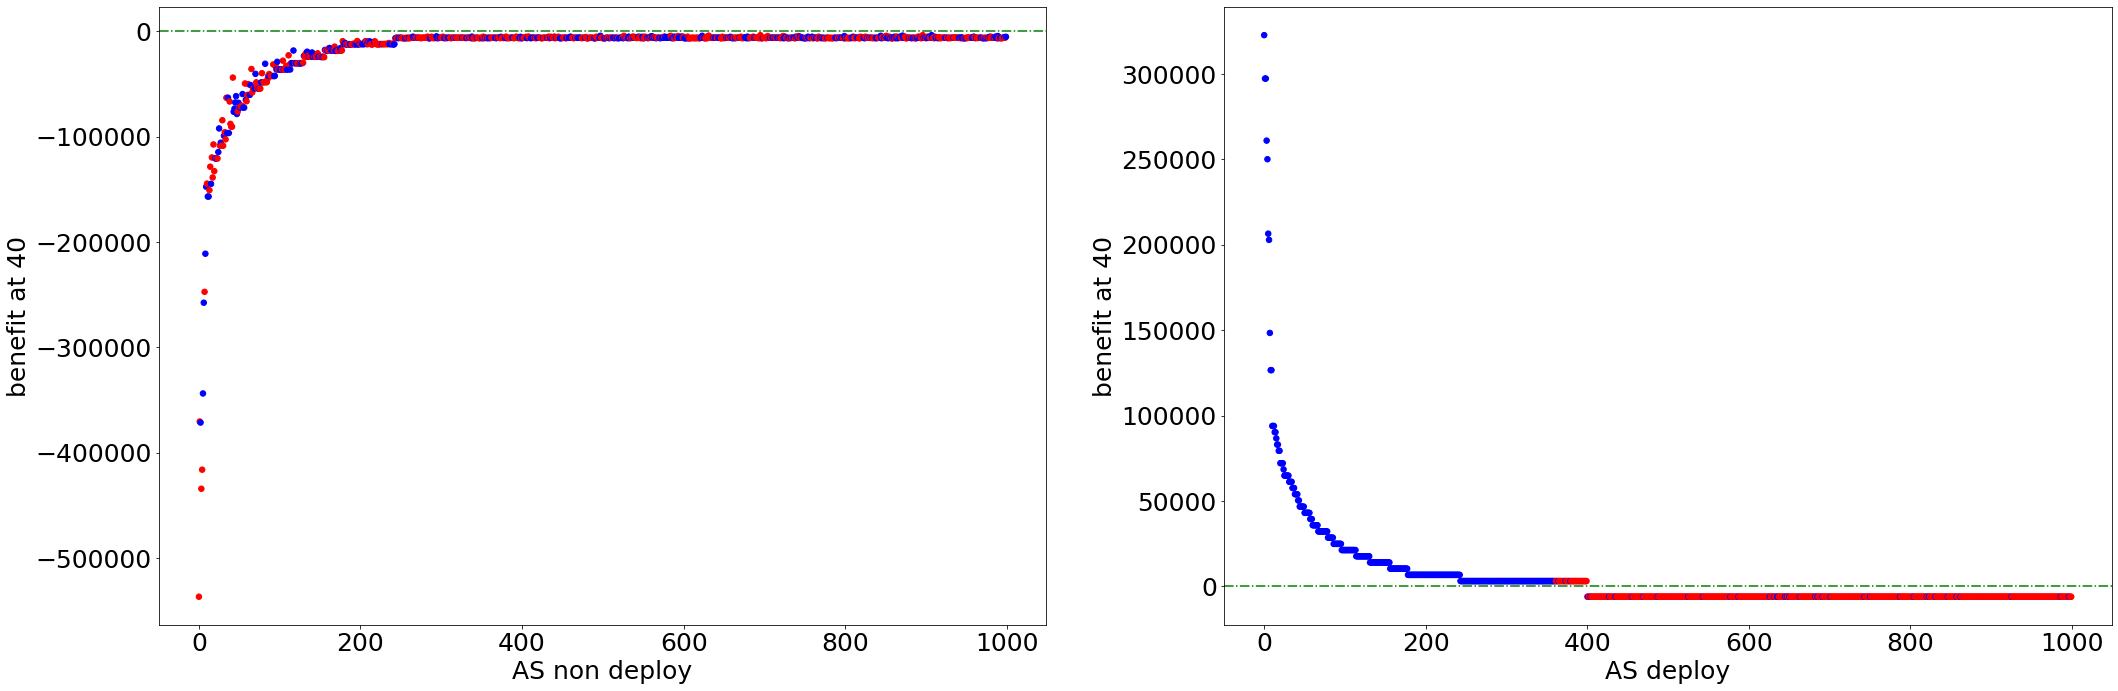

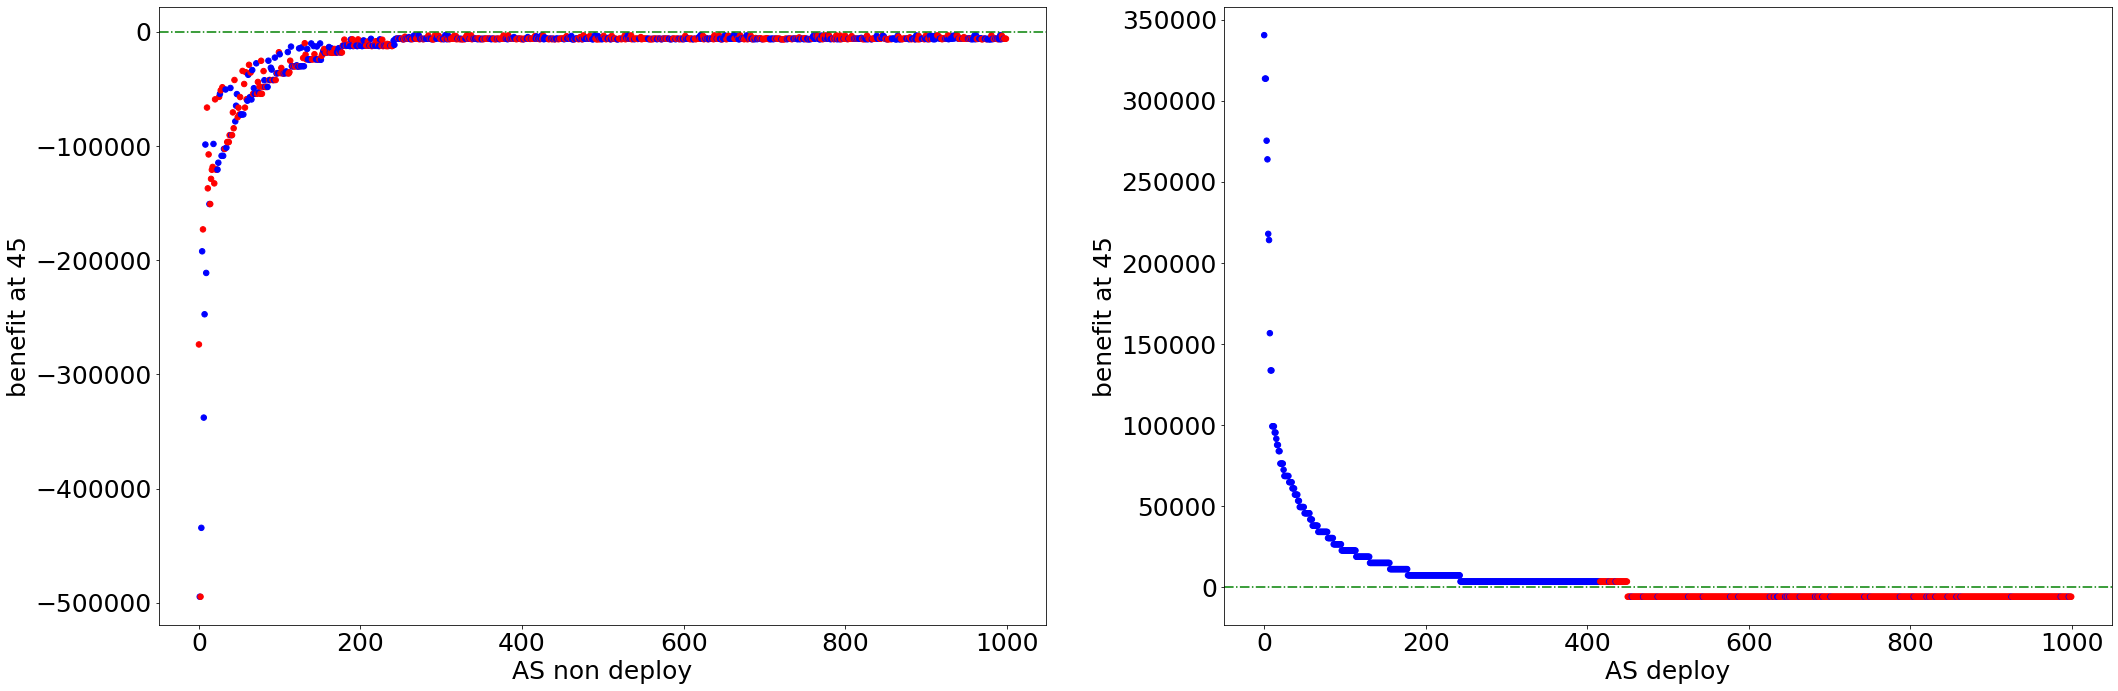

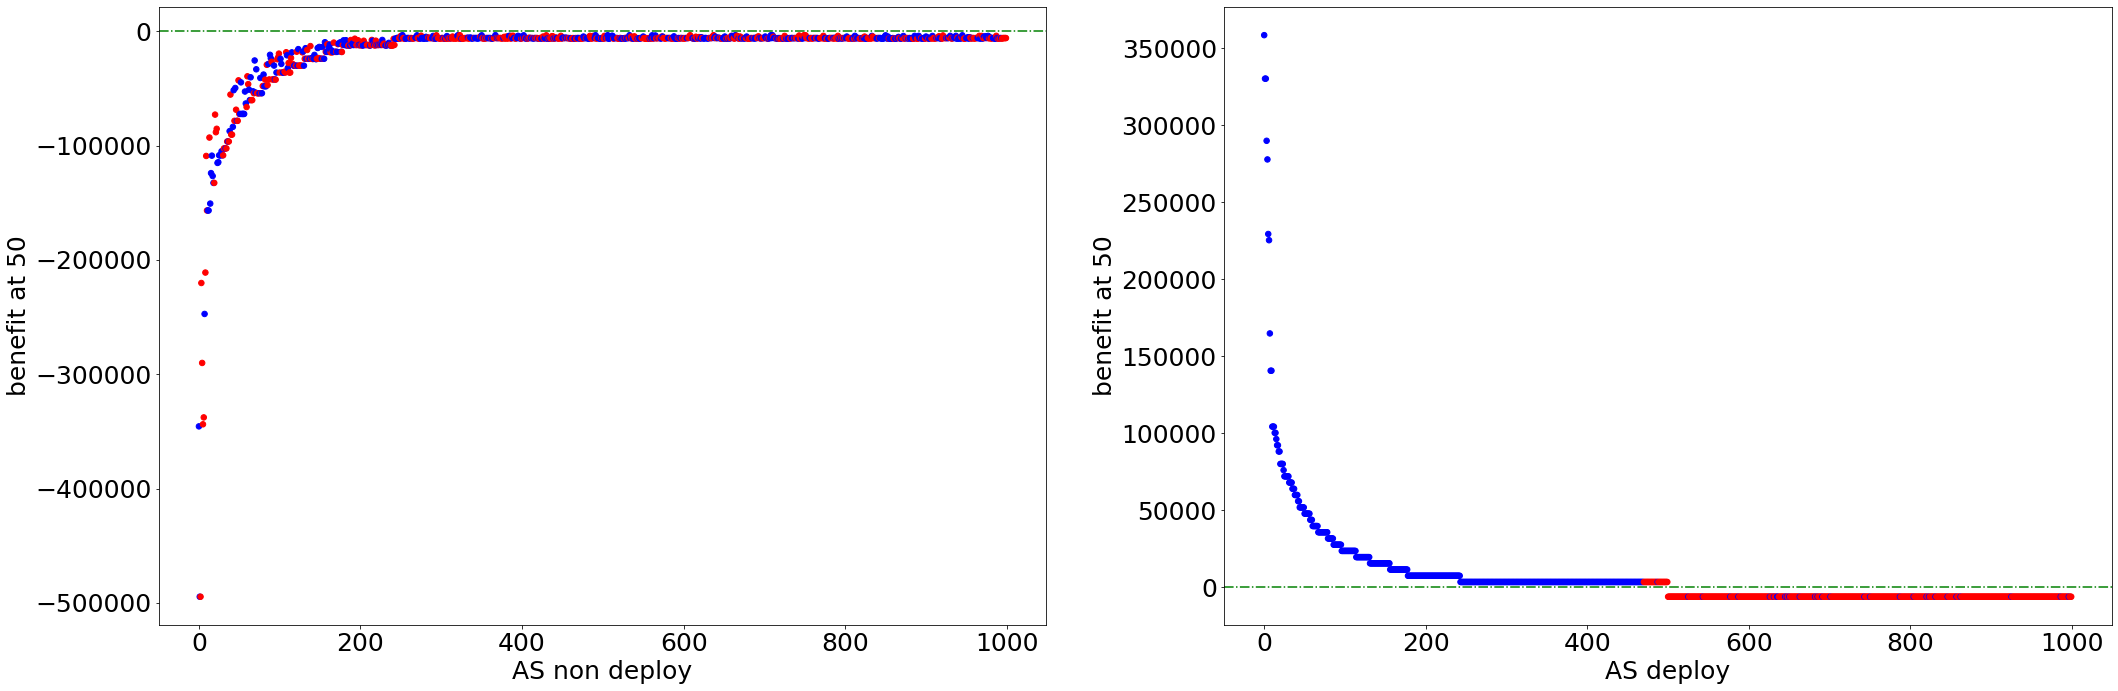

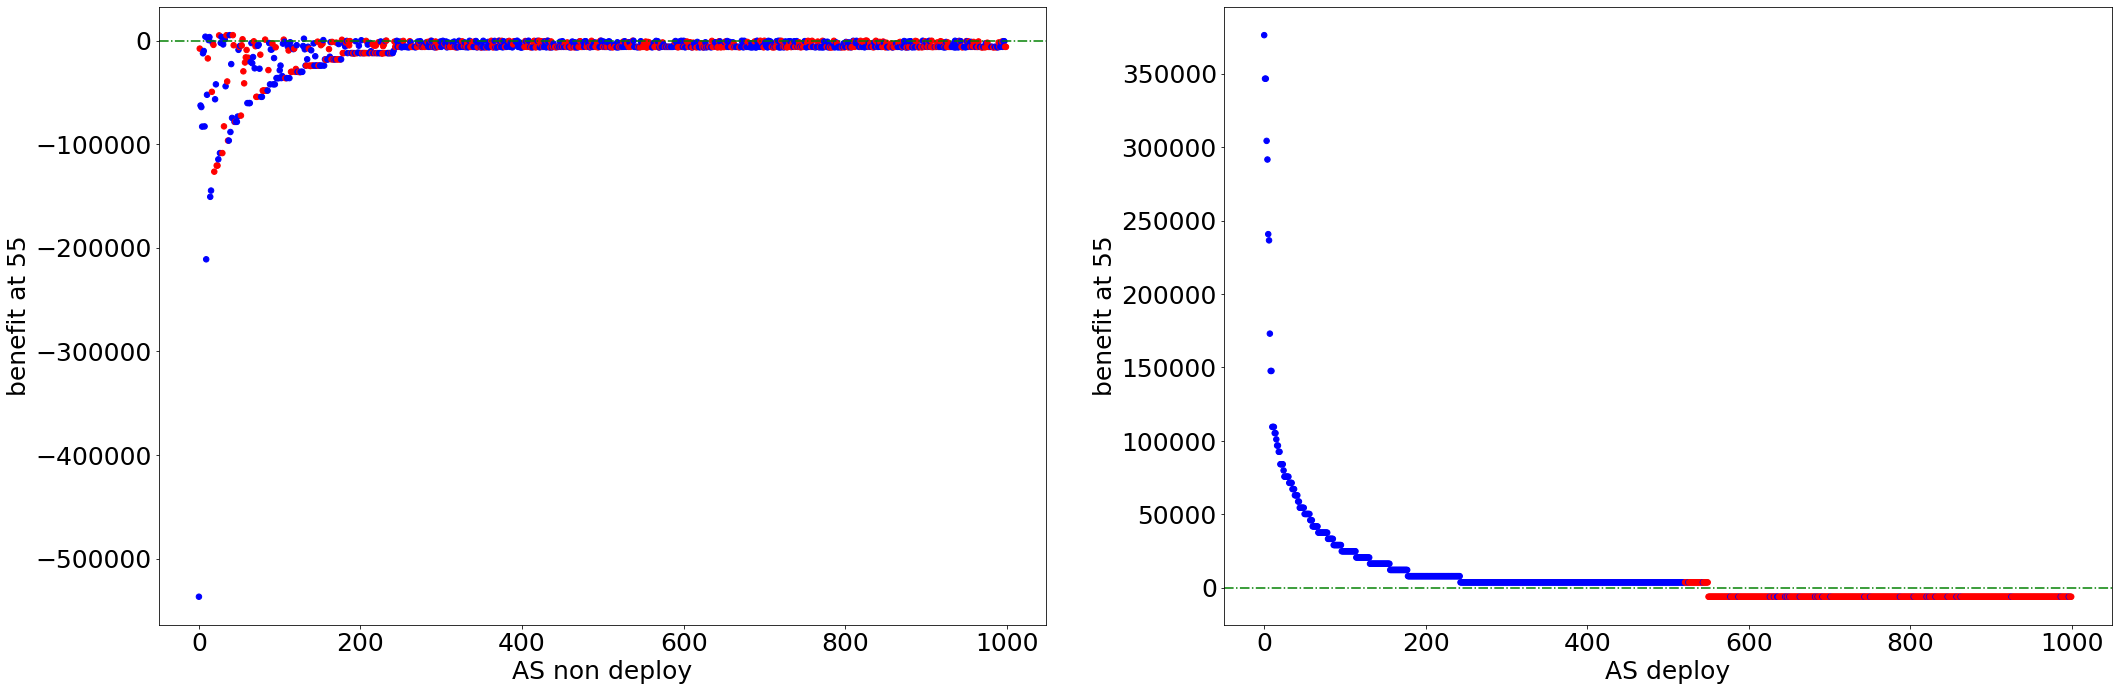

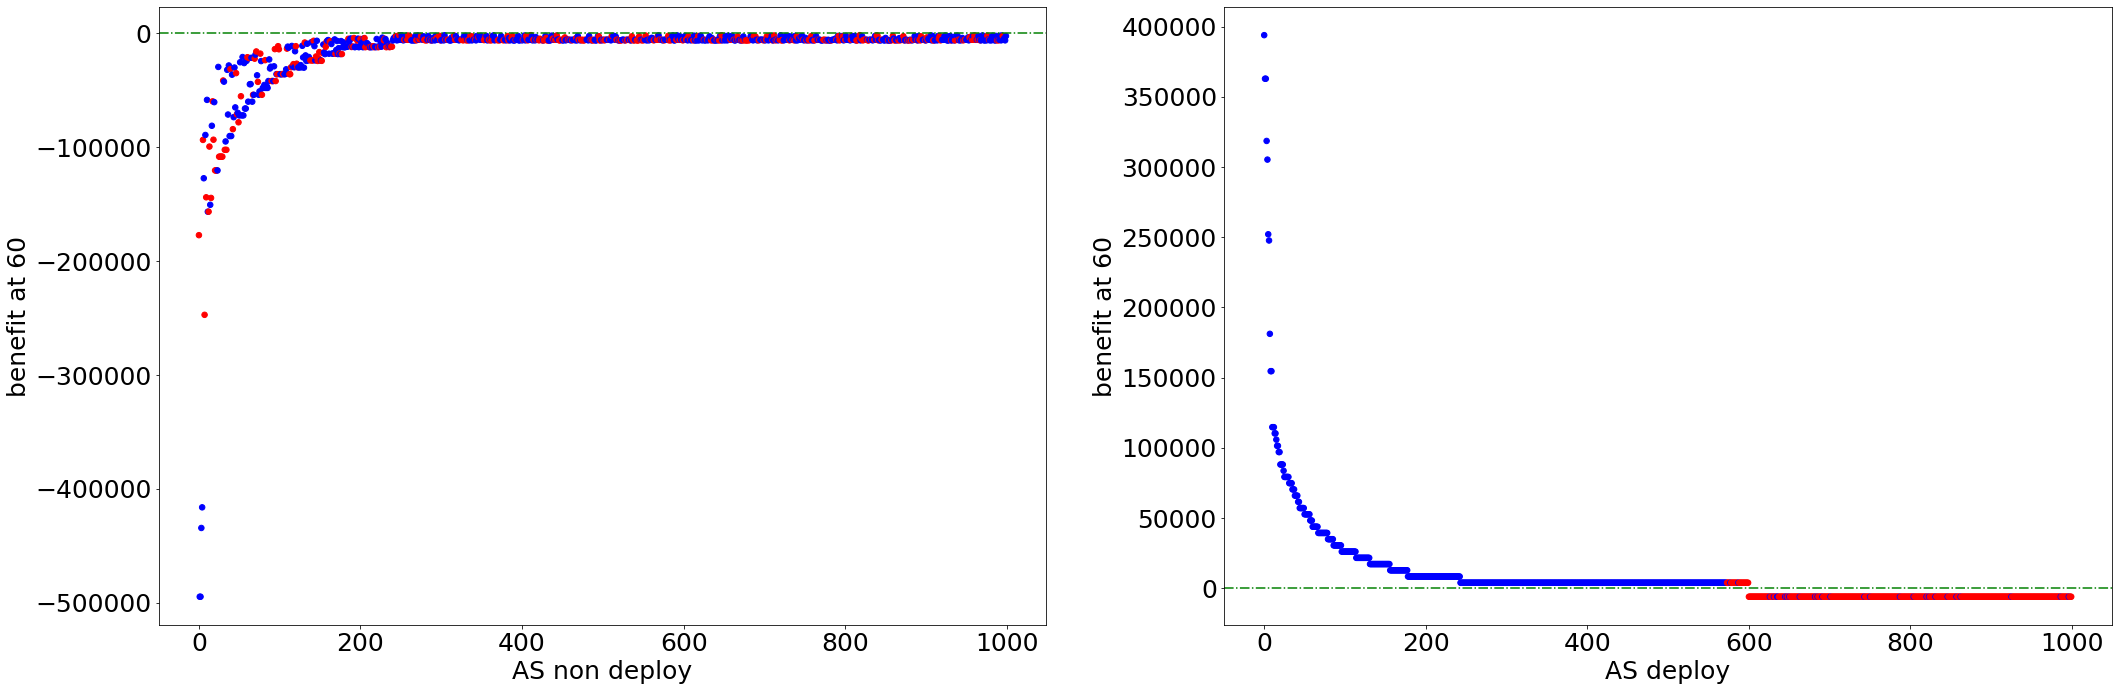

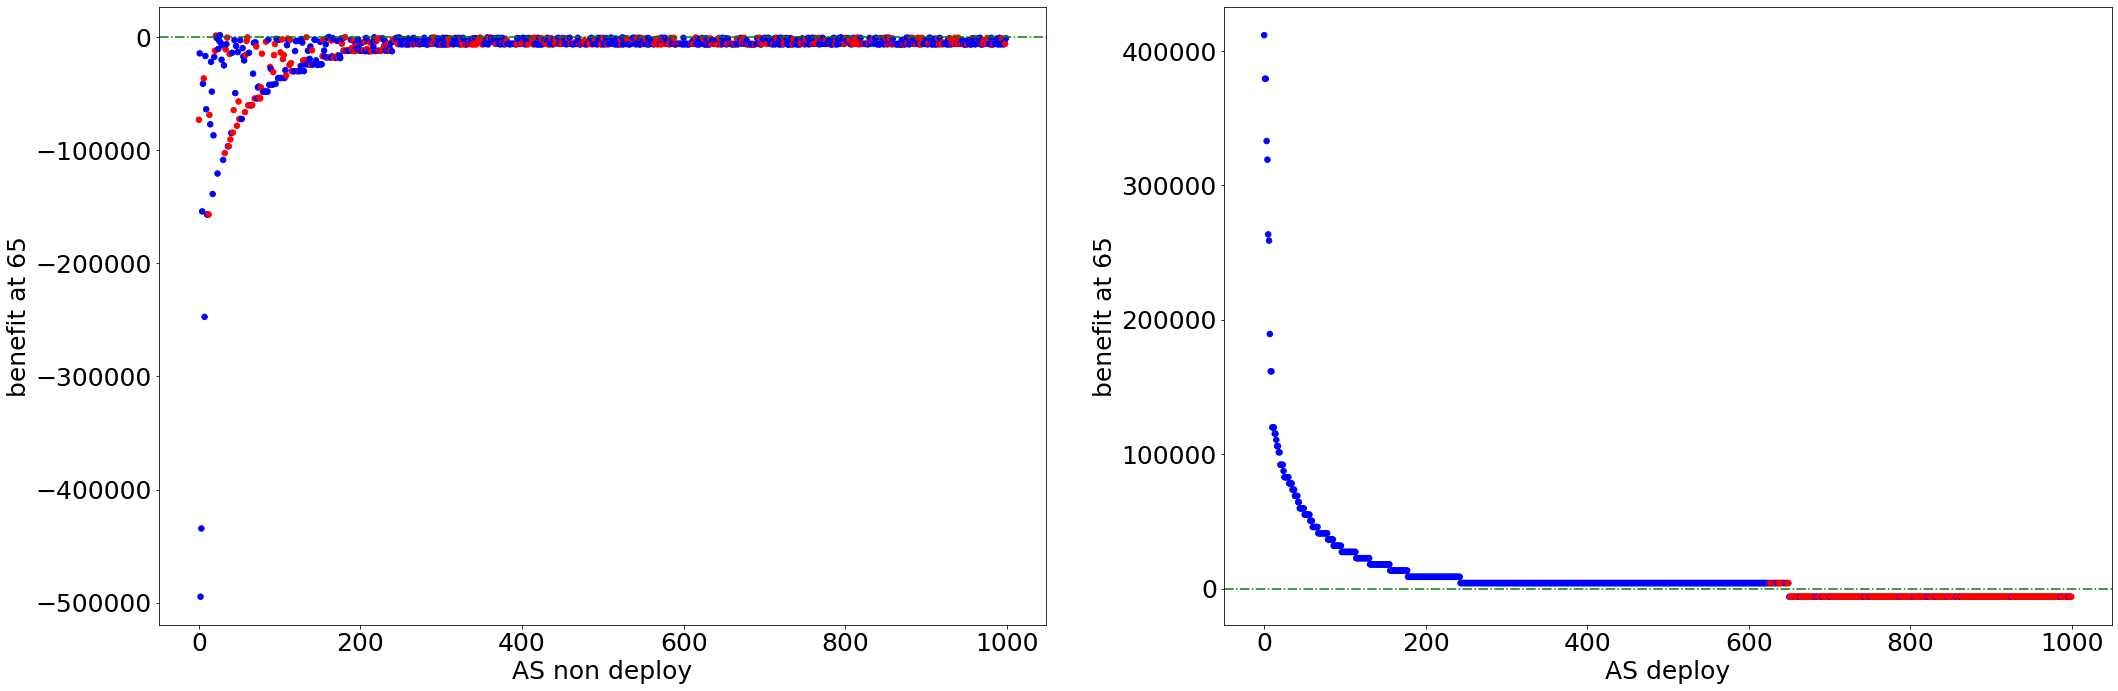

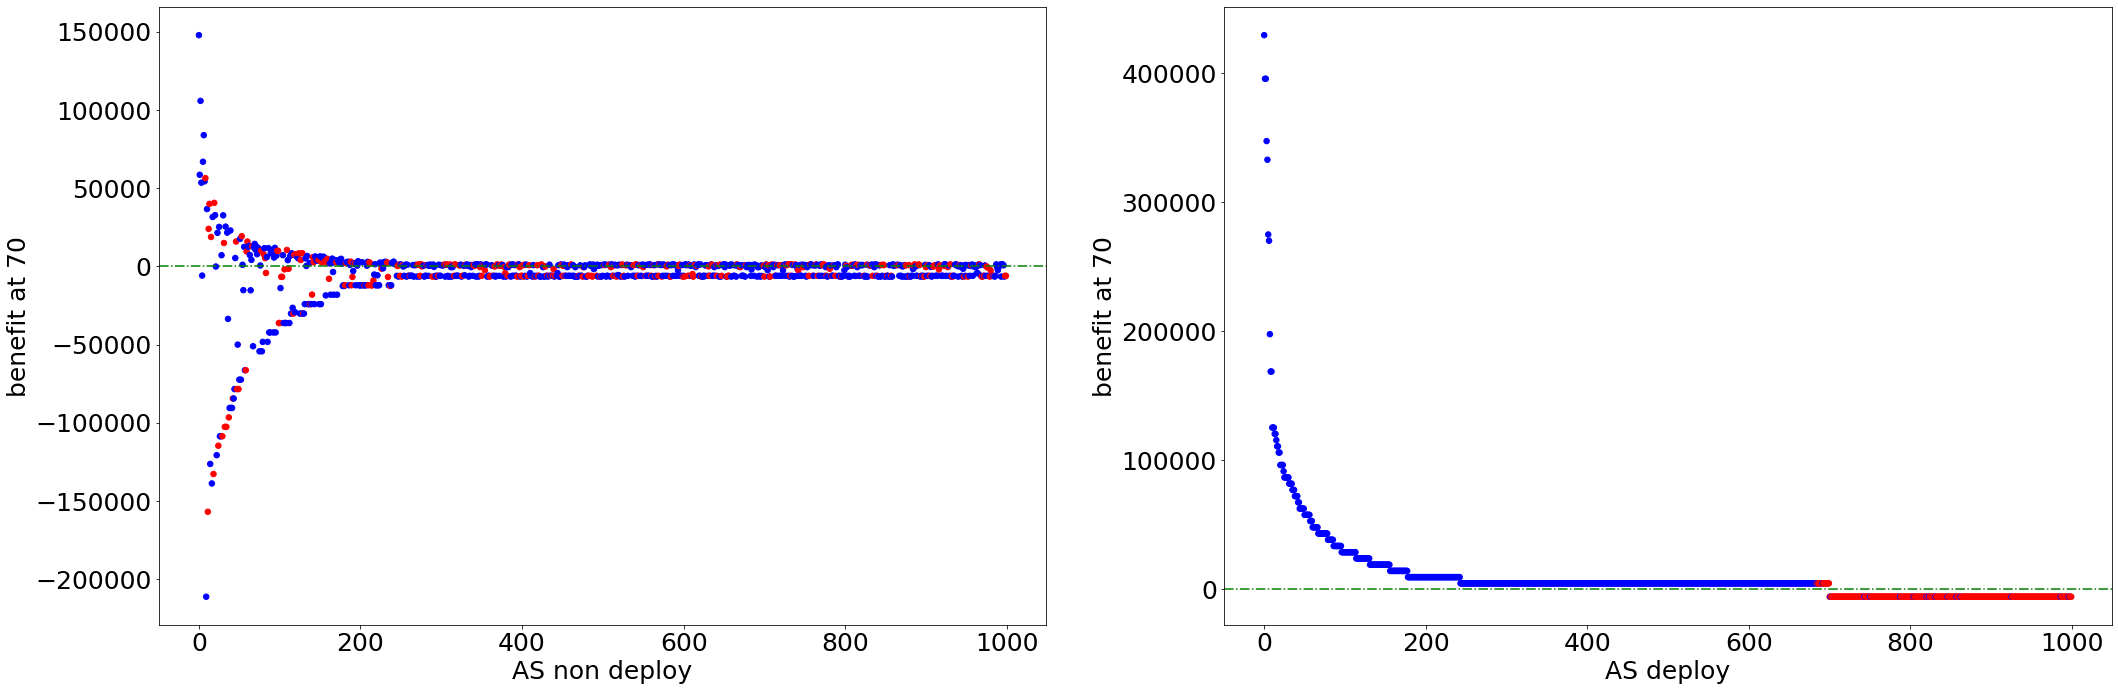

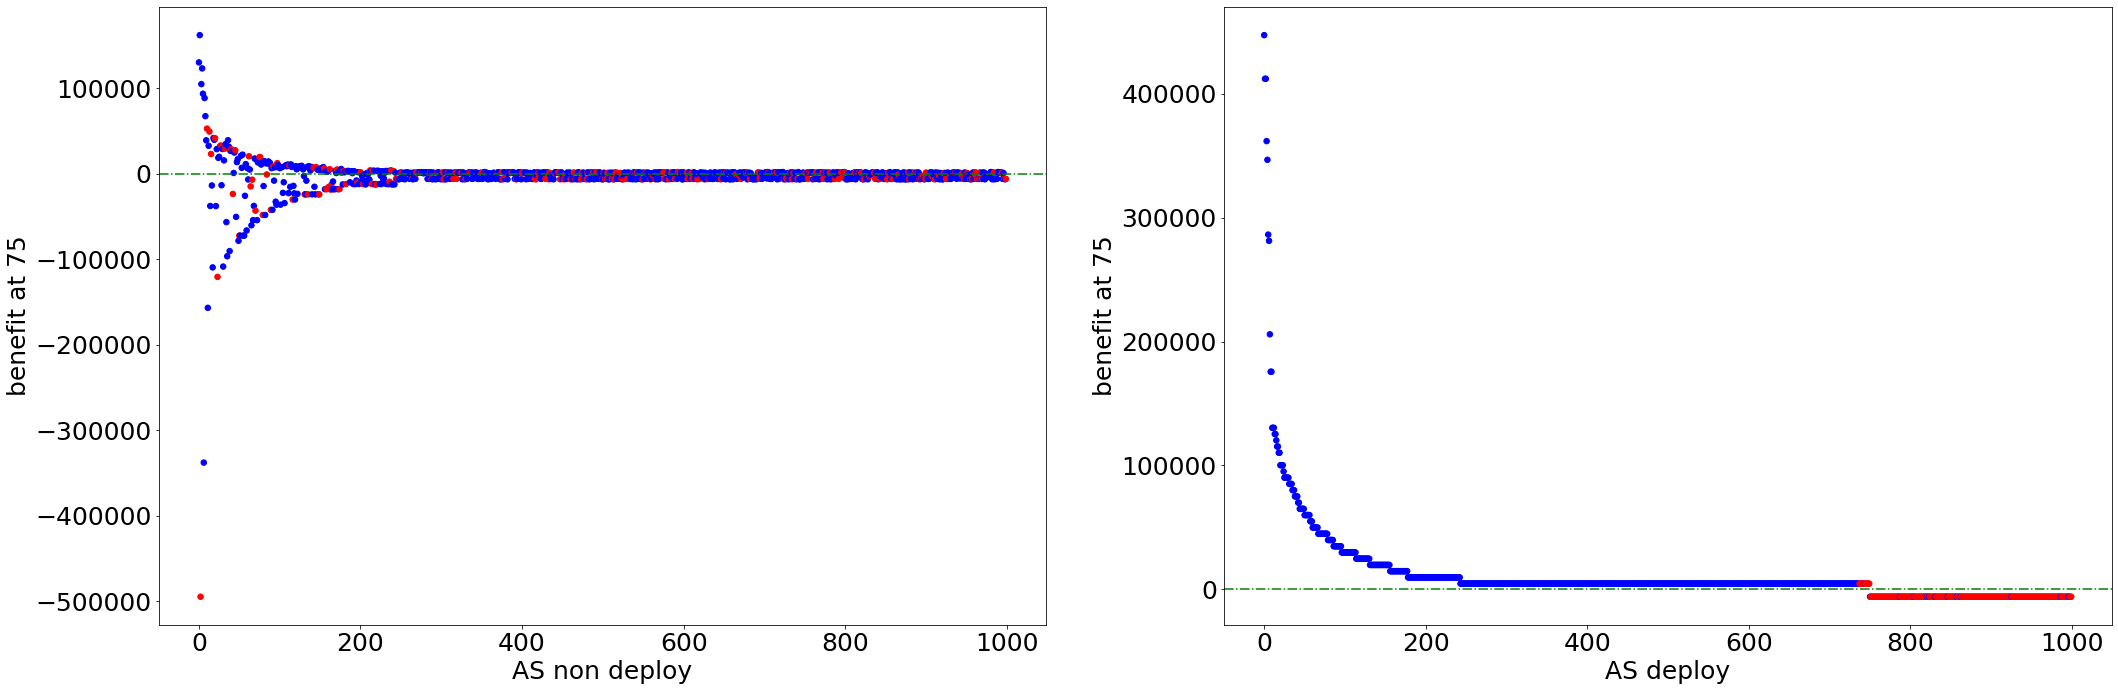

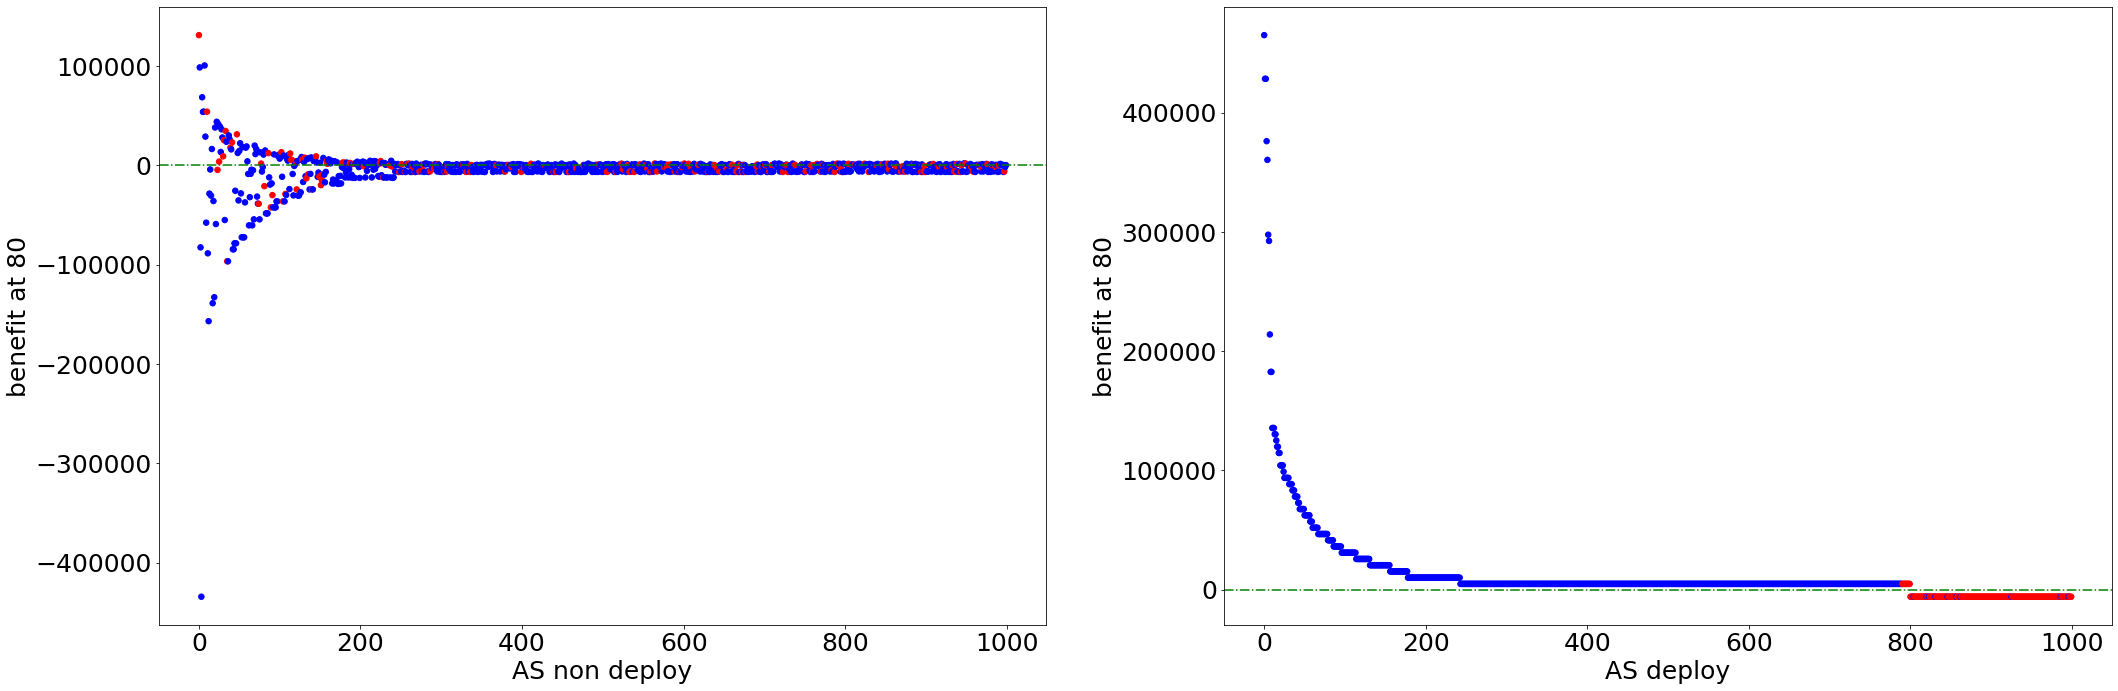

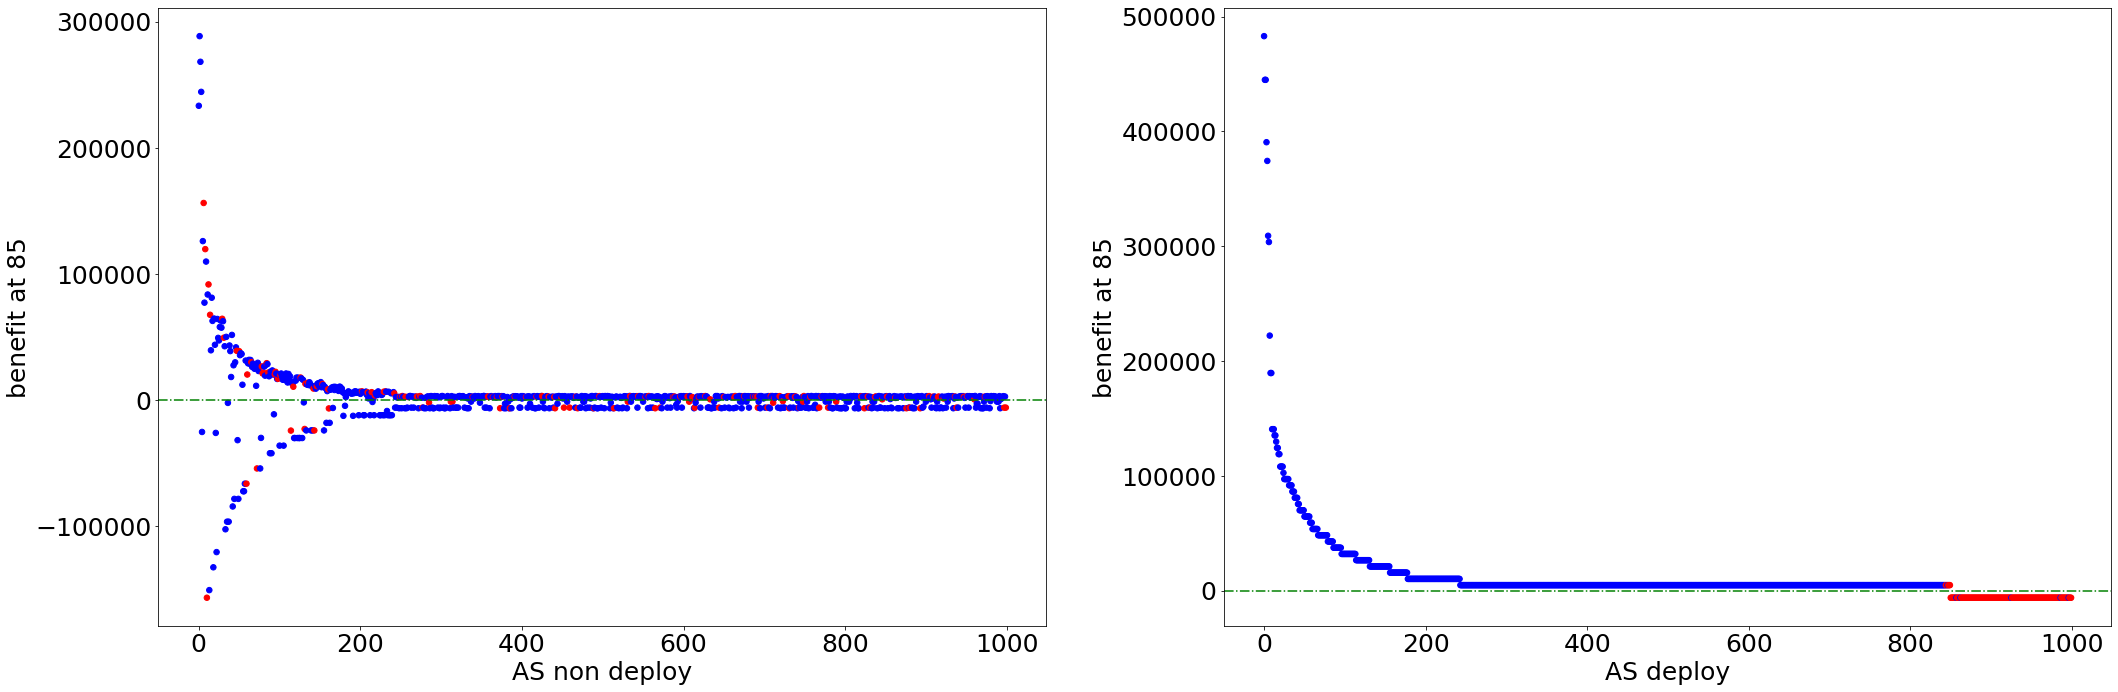

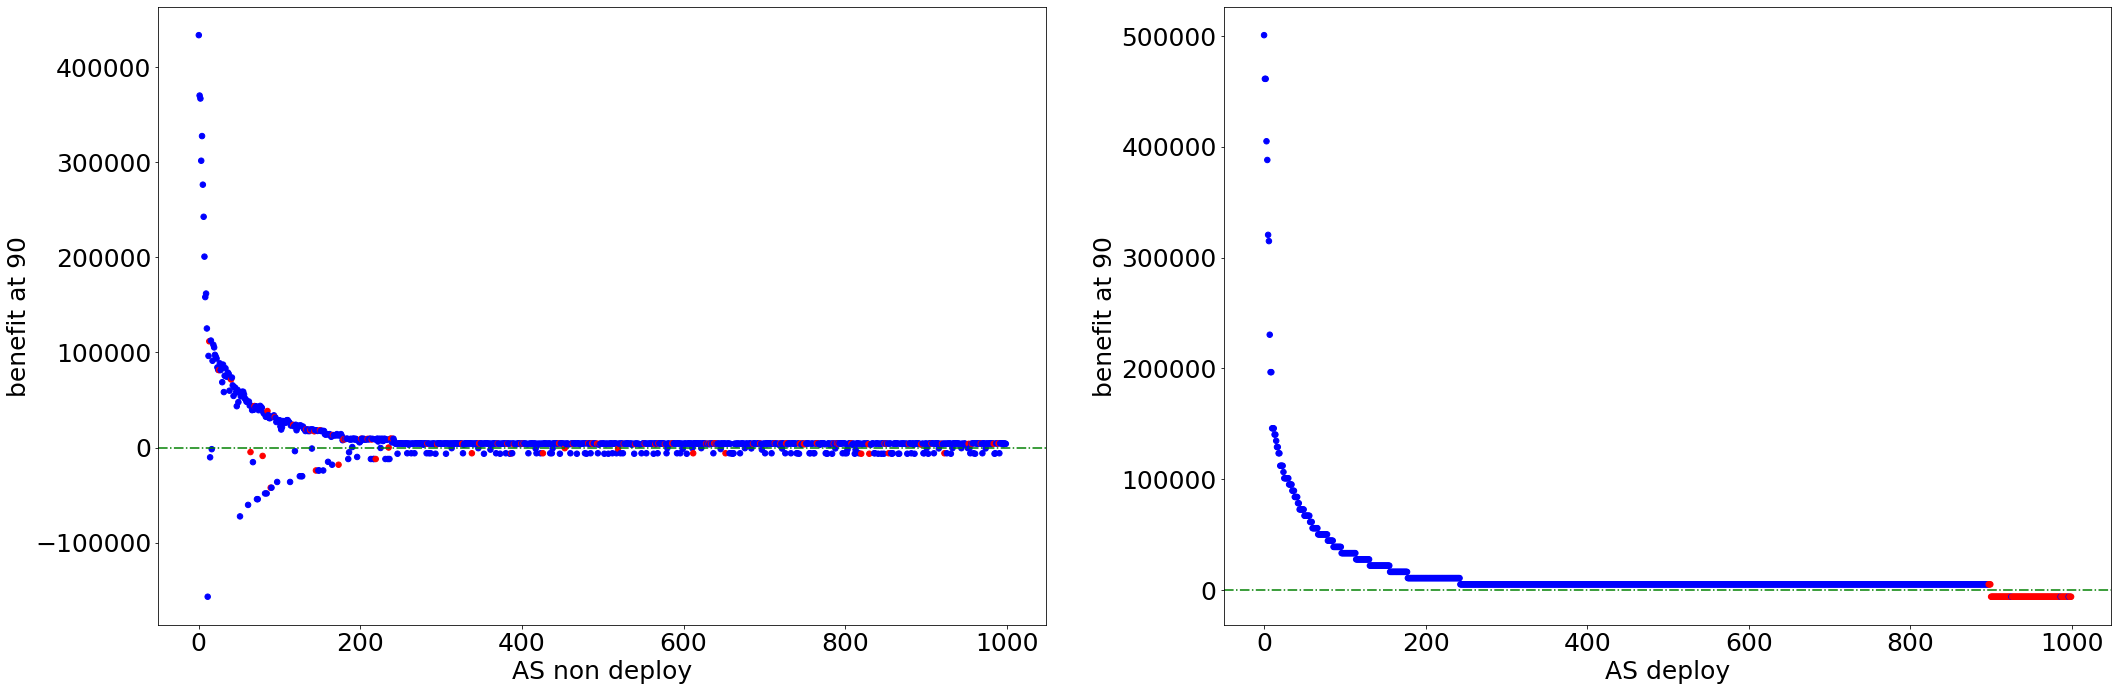

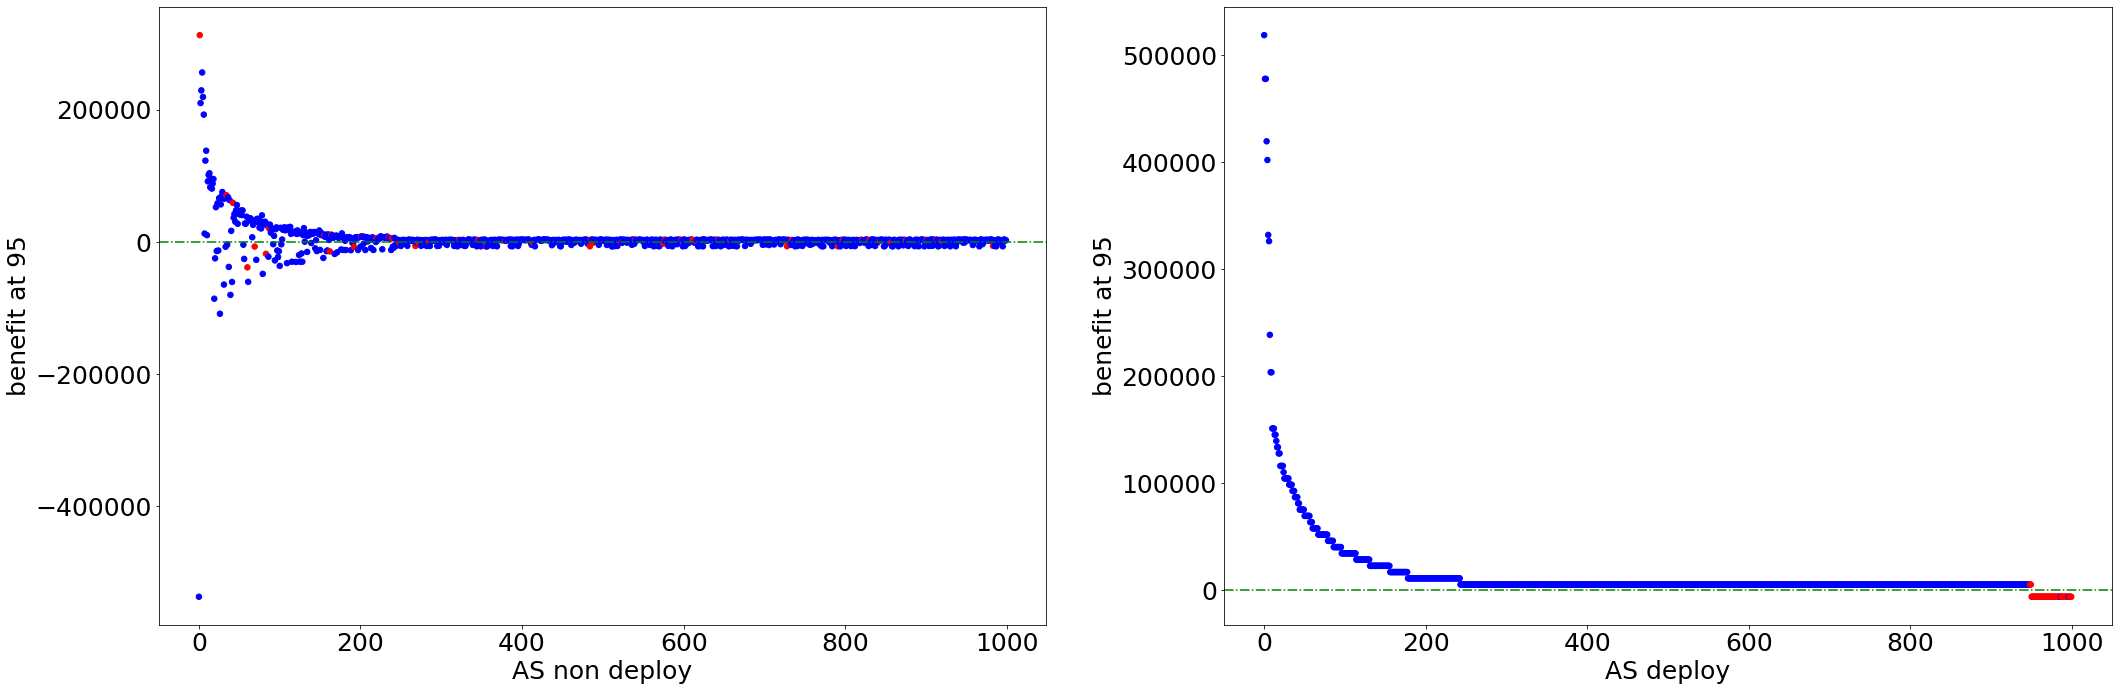

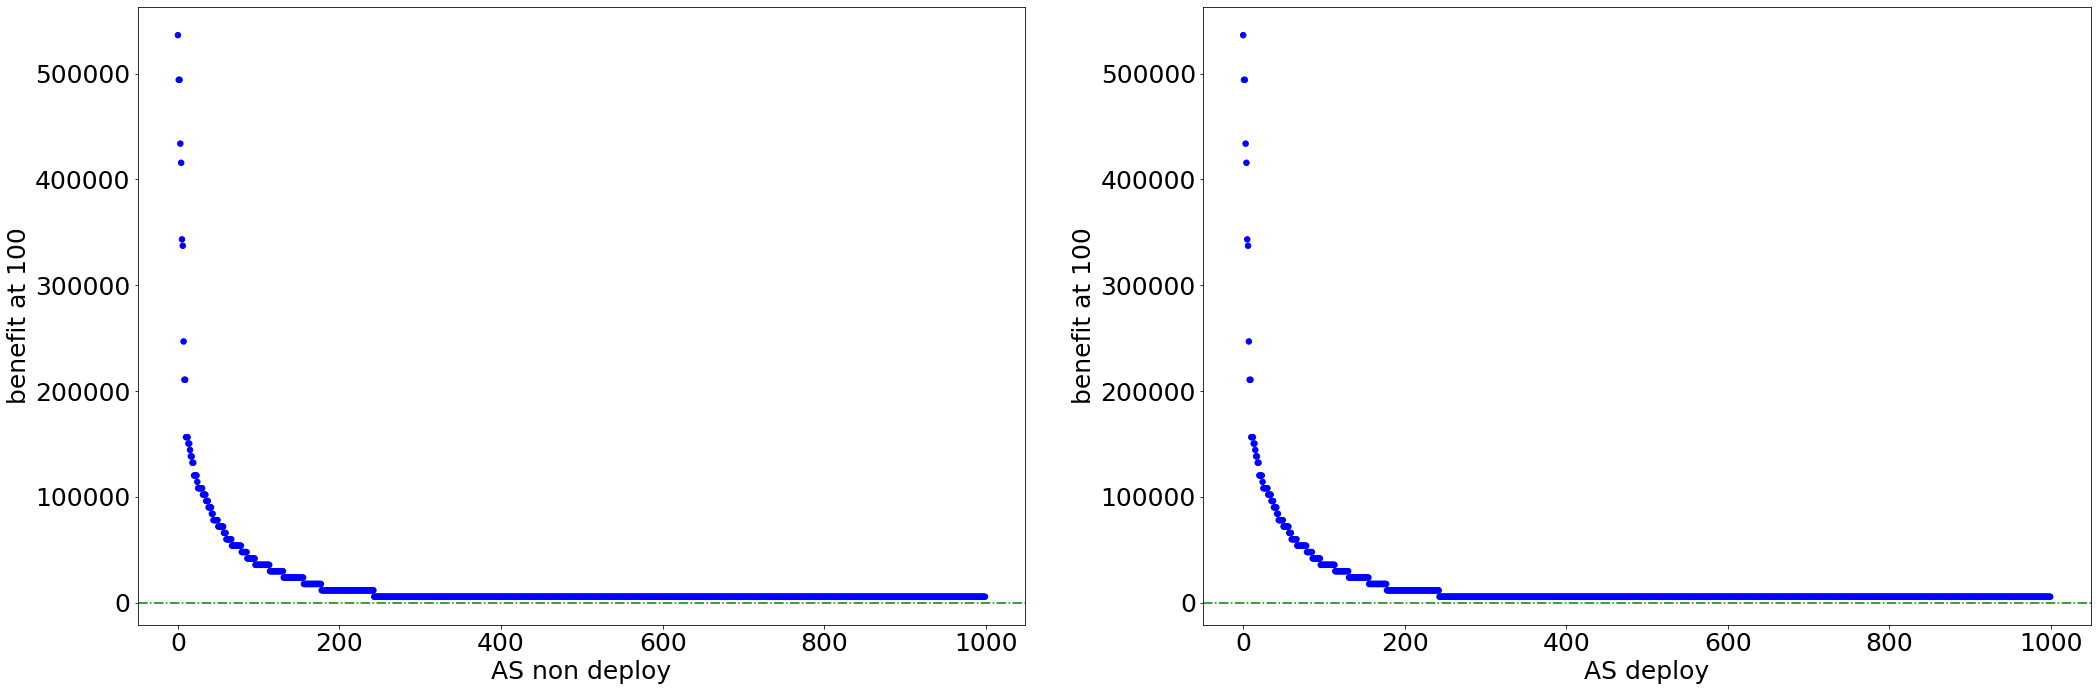

In [ ]:
#plotダメージ量の導入率での変化
for rate in range(0,105,5):
  fig = plt.figure(figsize = (35, 25))
  plt.rcParams["font.size"] = 25
  ax0 = fig.add_subplot(221)
#   plt.ylim([-2500,3000])
  ax1 = fig.add_subplot(222)
#   plt.ylim([-2500,3000])
  ax0.set_ylabel('benefit'+' at ' +str(rate))
  ax1.set_ylabel('benefit'+' at ' +str(rate))
  ax0.set_xlabel('AS non deploy')
  ax1.set_xlabel('AS deploy')
  ax0.scatter(list(range(len(node_list))),benefitdict[rate][0],color=benefitdict[rate][1],marker="o",s=30)
  ax1.scatter(list(range(len(node_list))),benefitdict[rate][2],color=benefitdict[rate][3],marker="o",s=30)
  ax0.axhline(0, ls = "-.", color = "g")
  ax1.axhline(0, ls = "-.", color = "g")
  # fig.set_xticklabels(mylist)
  # fig.savefig("/content/drive/MyDrive/graphs/"+str(rate)+"% at"+now+"img.png")
  # plt.rcParams["font.size"] = 18
  plt.show()
  

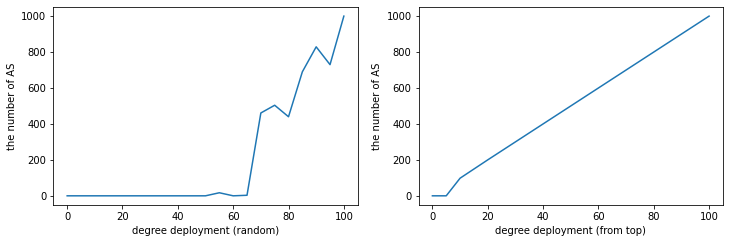

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 3, 461, 504, 440, 690, 829, 730, 1000] [0, 0, 98, 149, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100] 21 21


In [ ]:
#plot利益獲得AS数の変化
fig = plt.figure(figsize = (12, 8))
ax0 = fig.add_subplot(221)
# plt.ylim([0,40])
ax1 = fig.add_subplot(222)
# plt.ylim([0,40])
ax0.set_xlabel('degree deployment (random)')
ax1.set_xlabel('degree deployment (from top)')
ax0.set_ylabel('the number of AS')
ax1.set_ylabel('the number of AS')
ax0.plot((5*np.arange(len(numberlist0))).tolist(),numberlist0)
ax1.plot((5*np.arange(len(numberlist1))).tolist(),numberlist1)
# fig.set_xticklabels(mylist)
# fig.savefig(str(i)+str(dep_rate)+"img.png")
# fig.savefig("D:\\保存\\導入率と利益あるAS数img.png")
plt.show()
print(numberlist0,numberlist1)
print((5*np.arange(len(numberlist0))).tolist(),len((5*np.arange(len(numberlist0))).tolist()),len(numberlist0  
))

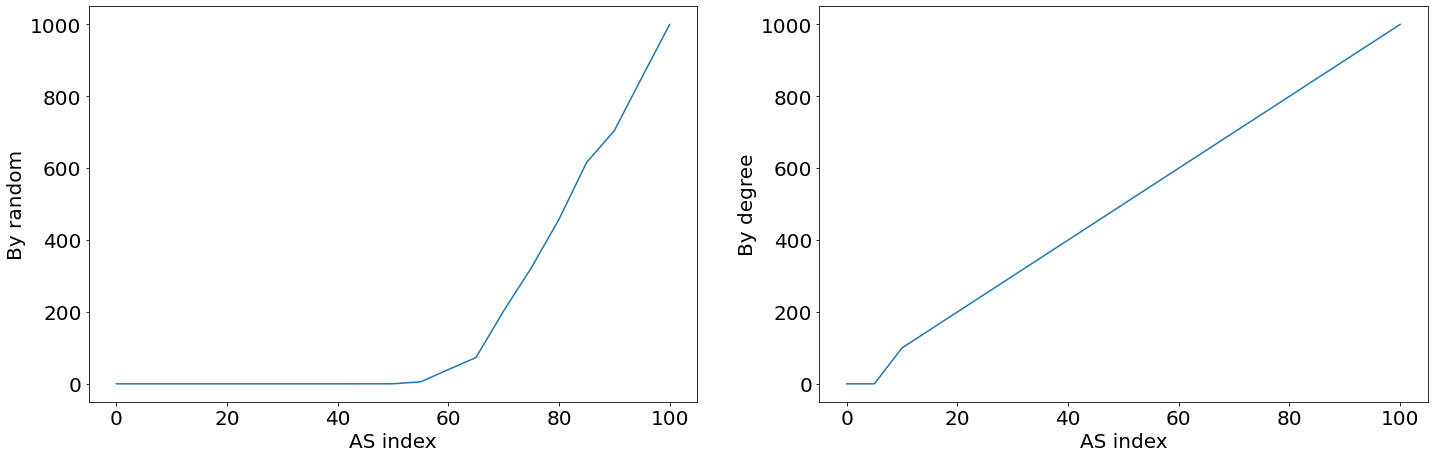

In [ ]:
#１００回やって平均したグラフ
import matplotlib.pyplot as plt
mylist1=[0.0, 0.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 500.0, 550.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0] 
mylist0=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06, 0.09, 5.57, 39.61, 73.07, 202.78, 322.67, 457.54, 616.05, 704.2, 852.92, 1000.0]
fig = plt.figure(figsize = (24, 16))
plt.rcParams["font.size"] = 20
ax0 = fig.add_subplot(221)
#   plt.ylim([-2500,3000])
ax1 = fig.add_subplot(222)
#   plt.ylim([-2500,3000])
ax0.set_ylabel('By random')
ax1.set_ylabel('By degree')
ax0.set_xlabel('AS index')
ax1.set_xlabel('AS index')
ax0.plot(list(range(0,105,5)),mylist0)
ax1.plot(list(range(0,105,5)),mylist1)
plt.show()

In [ ]:
import datetime
import numpy as np
now = str(datetime.datetime.now())

numberlist0=[]
numberlist1=[]
benefitdict={}


for rate in range(0,105,5):
  print(rate)
  damage_list=ratio_damage(rate)
  benefitdict[rate]=[damage_list[0],list(damage_list[2][2]),damage_list[1],list(damage_list[2][3])]

#   # print(damage_list)
#   fig = plt.figure(figsize = (35, 25))
#   plt.rcParams["font.size"] = 20
#   ax0 = fig.add_subplot(221)
# #   plt.ylim([-2500,3000])
#   ax1 = fig.add_subplot(222)
# #   plt.ylim([-2500,3000])
#   ax0.set_ylabel('benefit'+' at ' +str(rate))
#   ax1.set_ylabel('benefit'+' at ' +str(rate))
#   ax0.set_xlabel('AS non deploy')
#   ax1.set_xlabel('AS deploy')
#   ax0.scatter(list(range(len(node_list))),damage_list[0],color=list(damage_list[2][2]),marker=",",s=3)
#   ax1.scatter(list(range(len(node_list))),damage_list[1],color=list(damage_list[2][3]),marker=",",s=3)
#   ax0.axhline(0, ls = "-.", color = "g")
#   ax1.axhline(0, ls = "-.", color = "g")
#   # fig.set_xticklabels(mylist)
#   # fig.savefig("/content/drive/MyDrive/graphs/"+str(rate)+"% at"+now+"img.png")
#   # plt.rcParams["font.size"] = 18
#   plt.show()
  numberlist1.append(sum([i>=0 for i in damage_list[1]]))
  numberlist0.append(sum([i>=0 for i in damage_list[0]]))
#   print(damage_list[0])
#   print(damage_list[1])
  

# print("Ok")
# fig = plt.figure(figsize = (12, 8))
# ax0 = fig.add_subplot(221)
# # plt.ylim([0,40])
# ax1 = fig.add_subplot(222)
# # plt.ylim([0,40])
# ax0.set_xlabel('degree deployment (random)')
# ax1.set_xlabel('degree deployment (from top)')
# ax0.set_ylabel('the number of AS')
# ax1.set_ylabel('the number of AS')
# ax0.plot(5*np.arange(len(numberlist0)).tolist(),numberlist0)
# ax1.plot(5*np.arange(len(numberlist1)).tolist(),numberlist1)
# # fig.set_xticklabels(mylist)
# # fig.savefig(str(i)+str(dep_rate)+"img.png")
# # fig.savefig("/content/drive/MyDrive/graphs/導入率と利益あるAS数"+now+"img.png")
# plt.show()
  print(numberlist0,numberlist1)

0
[0] [0]
5
[0, 0] [0, 0]
10
[0, 0, 0] [0, 0, 98]
15
[0, 0, 0, 0] [0, 0, 98, 149]
20
[0, 0, 0, 0, 0] [0, 0, 98, 149, 200]
25
[0, 0, 0, 0, 0, 0] [0, 0, 98, 149, 200, 250]
30
[0, 0, 0, 0, 0, 0, 0] [0, 0, 98, 149, 200, 250, 300]
35
[0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 98, 149, 200, 250, 300, 350]
40
[0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 98, 149, 200, 250, 300, 350, 400]
45
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 98, 149, 200, 250, 300, 350, 400, 450]
50
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 98, 149, 200, 250, 300, 350, 400, 450, 500]
55
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17] [0, 0, 98, 149, 200, 250, 300, 350, 400, 450, 500, 550]
60
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0] [0, 0, 98, 149, 200, 250, 300, 350, 400, 450, 500, 550, 600]
65
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 3] [0, 0, 98, 149, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650]
70
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 3, 461] [0, 0, 98, 149, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
75
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0

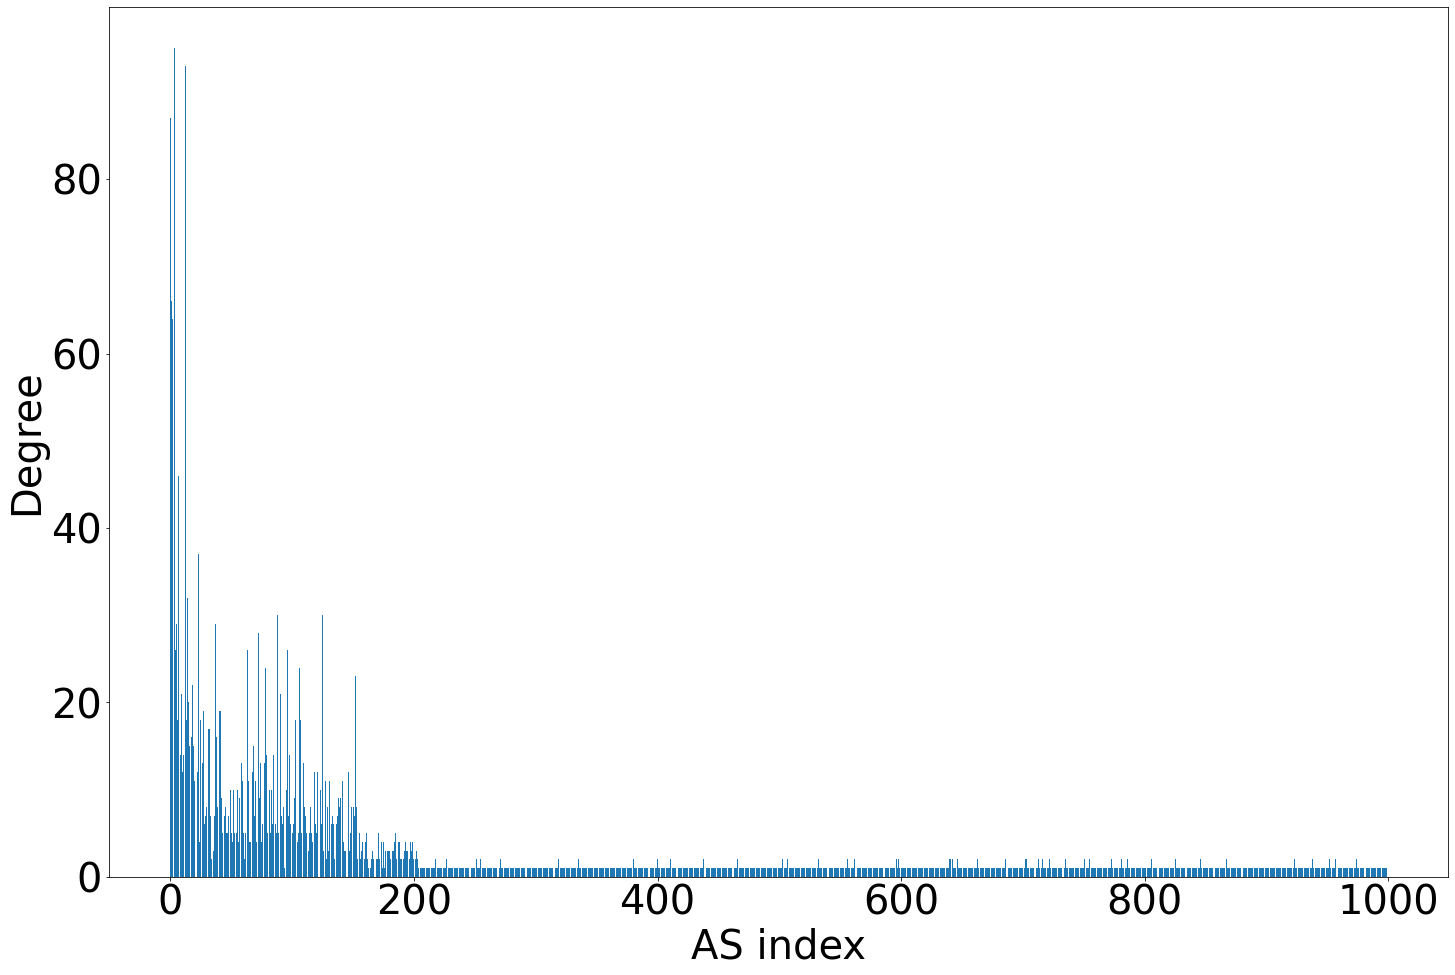

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (24, 16))
plt.rcParams["font.size"] = 40
ax0 = fig.add_subplot(111)
#   plt.ylim([-2500,3000])
ax0.set_ylabel('Degree')
ax0.set_xlabel('AS index')
ax0.bar(node_list,[nx.degree(G)[node]/2 for node in node_list])

plt.show()

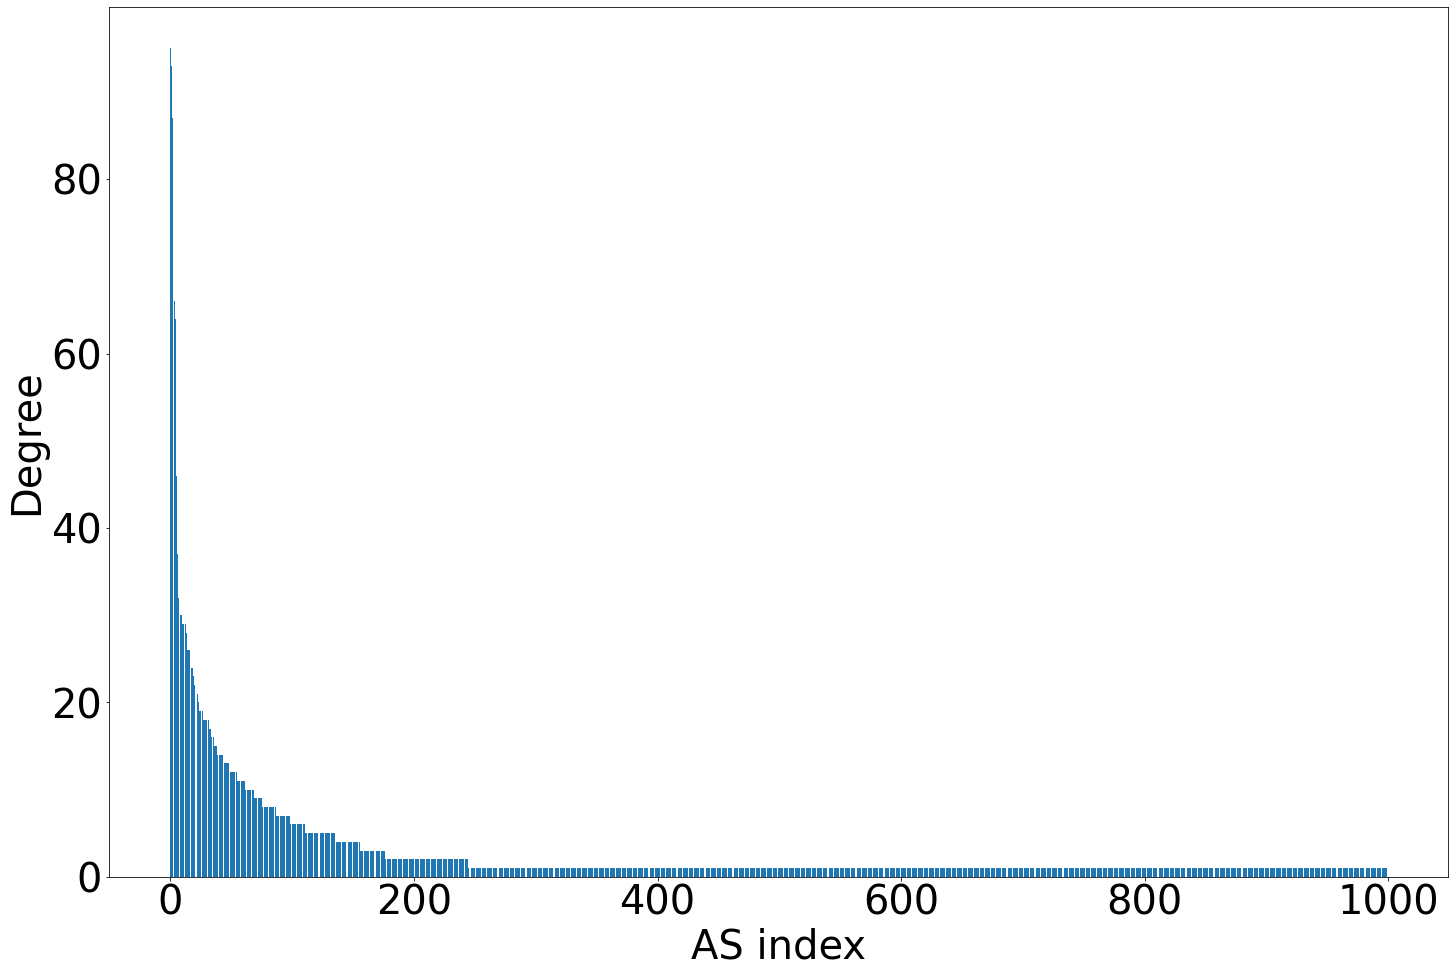

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (24, 16))
plt.rcParams["font.size"] = 40
ax0 = fig.add_subplot(111)
#   plt.ylim([-2500,3000])
ax0.set_ylabel('Degree')
ax0.set_xlabel('AS index')
ax0.bar(list(range(1000)),[nx.degree(G)[node]/2 for node in node_list])

plt.show()

In [ ]:
# import pickle
# with open('/content/drive/MyDrive/datafile/benefitdictionary.binaryfile', 'wb') as web:
#   pickle.dump(benefitdict , web)

In [ ]:
for k,v in dict(G.nodes()).items():
  print(k,v) 
print(dict(G.nodes())['nodepDamage'])
for node in list(G.nodes()):
  print(int(nx.degree(G)[node]/2),dict(G.nodes())[node]['nodepDamage'],dict(G.nodes())[node]['nodepDamage']/int(nx.degree(G)[node]/2))

0 {'type': 'T', 'nodepDamage': 246984, 'rpki': 'b', 'Cost': 500, 'damage0': 0, 'top_rpki': 'b', 'top_Cost': 500, 'damage1': 0}
1 {'type': 'T', 'nodepDamage': 397584, 'rpki': 'b', 'Cost': 500, 'damage0': 0, 'top_rpki': 'b', 'top_Cost': 500, 'damage1': 0}
2 {'type': 'T', 'nodepDamage': 445776, 'rpki': 'b', 'Cost': 500, 'damage0': 0, 'top_rpki': 'b', 'top_Cost': 500, 'damage1': 0}
3 {'type': 'T', 'nodepDamage': 518064, 'rpki': 'b', 'Cost': 500, 'damage0': 0, 'top_rpki': 'b', 'top_Cost': 500, 'damage1': 0}
4 {'type': 'T', 'nodepDamage': 313248, 'rpki': 'b', 'Cost': 500, 'damage0': 0, 'top_rpki': 'b', 'top_Cost': 500, 'damage1': 0}
5 {'type': 'M', 'peers': 0, 'nodepDamage': 409632, 'rpki': 'b', 'Cost': 500, 'damage0': 0, 'top_rpki': 'b', 'top_Cost': 500, 'damage1': 0}
6 {'type': 'M', 'peers': 23, 'nodepDamage': 192768, 'rpki': 'b', 'Cost': 500, 'damage0': 0, 'top_rpki': 'b', 'top_Cost': 500, 'damage1': 0}
7 {'type': 'M', 'peers': 0, 'nodepDamage': 72288, 'rpki': 'b', 'Cost': 500, 'damage0':

KeyError: ignored